In [ ]:
# Import necessary libraries
from google.colab import drive
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths for the source, encrypted, decrypted, and resized image folders
image_folder_path = '/content/drive/MyDrive/dataset/Images'
encrypted_folder_path ='/content/drive/MyDrive/dataset/encrypted image'
decrypted_folder_path = '/content/drive/MyDrive/dataset/decrypted image'
image_folder_path1 = '/content/drive/MyDrive/dataset/sample image1'  # Folder for resized images

In [ ]:
# Function to load a limited number of images from a folder and resize them to (64, 64)
def load_images_from_folder(folder, size=(128, 128), limit=2000):
    images = []
    filenames = []
    for i, filename in enumerate(tqdm(os.listdir(folder), desc="Loading images")):
        if i >= limit:  # Stop after reaching the specified limit
            break
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
            img = img.resize(size, Image.Resampling.LANCZOS)  # Replace Image.ANTIALIAS with Image.Resampling.LANCZOS
            img_array = np.array(img)
            images.append(img_array)
            filenames.append(filename)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), filenames


In [ ]:
# Load and resize original images
images, filenames = load_images_from_folder(image_folder_path, size=(128, 128), limit=20)


Loading images:   0%|          | 20/8101 [00:05<34:41,  3.88it/s]


In [ ]:
# Logistic map function
def logistic(x):
    mu = 3.57999099
    return x * (1 - x) * mu

In [ ]:
# Image encryption function
def encrypt_image(img_array):
    row, col, channels = img_array.shape
    encrypted_img_array = np.zeros_like(img_array, dtype=np.uint32)

    q = 0.8976
    C = np.zeros((channels, row * col), dtype=np.uint32)

    for ch in range(channels):
        im = img_array[:, :, ch].flatten().astype(np.uint32)
        C[ch][0] = 253
        n = C[ch][0]

        # Encryption loop
        for i in range(1, len(im)):
            q = logistic(q)
            if np.isnan(q) or np.isnan(n) or n == 0:
                b = 1
            else:
                b = int(np.mod(np.floor(q * (2**14)), n) + 1)
            C[ch][i] = np.bitwise_xor(np.bitwise_xor(im[i-1], C[ch][i-1]), np.uint32(b))

        encrypted_img_array[:, :, ch] = np.reshape(C[ch], (row, col))

    return encrypted_img_array.astype(np.uint8)


In [ ]:
# Image decryption function
def decrypt_image(encrypted_img_array):
    row, col, channels = encrypted_img_array.shape
    decrypted_img_array = np.zeros_like(encrypted_img_array, dtype=np.uint32)

    q = 0.8976

    for ch in range(channels):
        im = encrypted_img_array[:, :, ch].flatten().astype(np.uint32)
        C = np.zeros_like(im, dtype=np.uint32)
        n = im[0]

        for i in range(1, len(im)):
            q = logistic(q)
            if np.isnan(q) or np.isnan(n) or n == 0:
                b = 1
            else:
                b = int(np.mod(np.floor(q * (2**14)), n) + 1)
            C[i-1] = np.bitwise_xor(np.bitwise_xor(np.uint32(im[i]), np.uint32(im[i-1])), np.uint32(b))

        decrypted_img_array[:, :, ch] = np.reshape(C, (row, col))

    return decrypted_img_array.astype(np.uint8)

Encrypting images...


Encryption: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Decrypting images...


Decryption: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


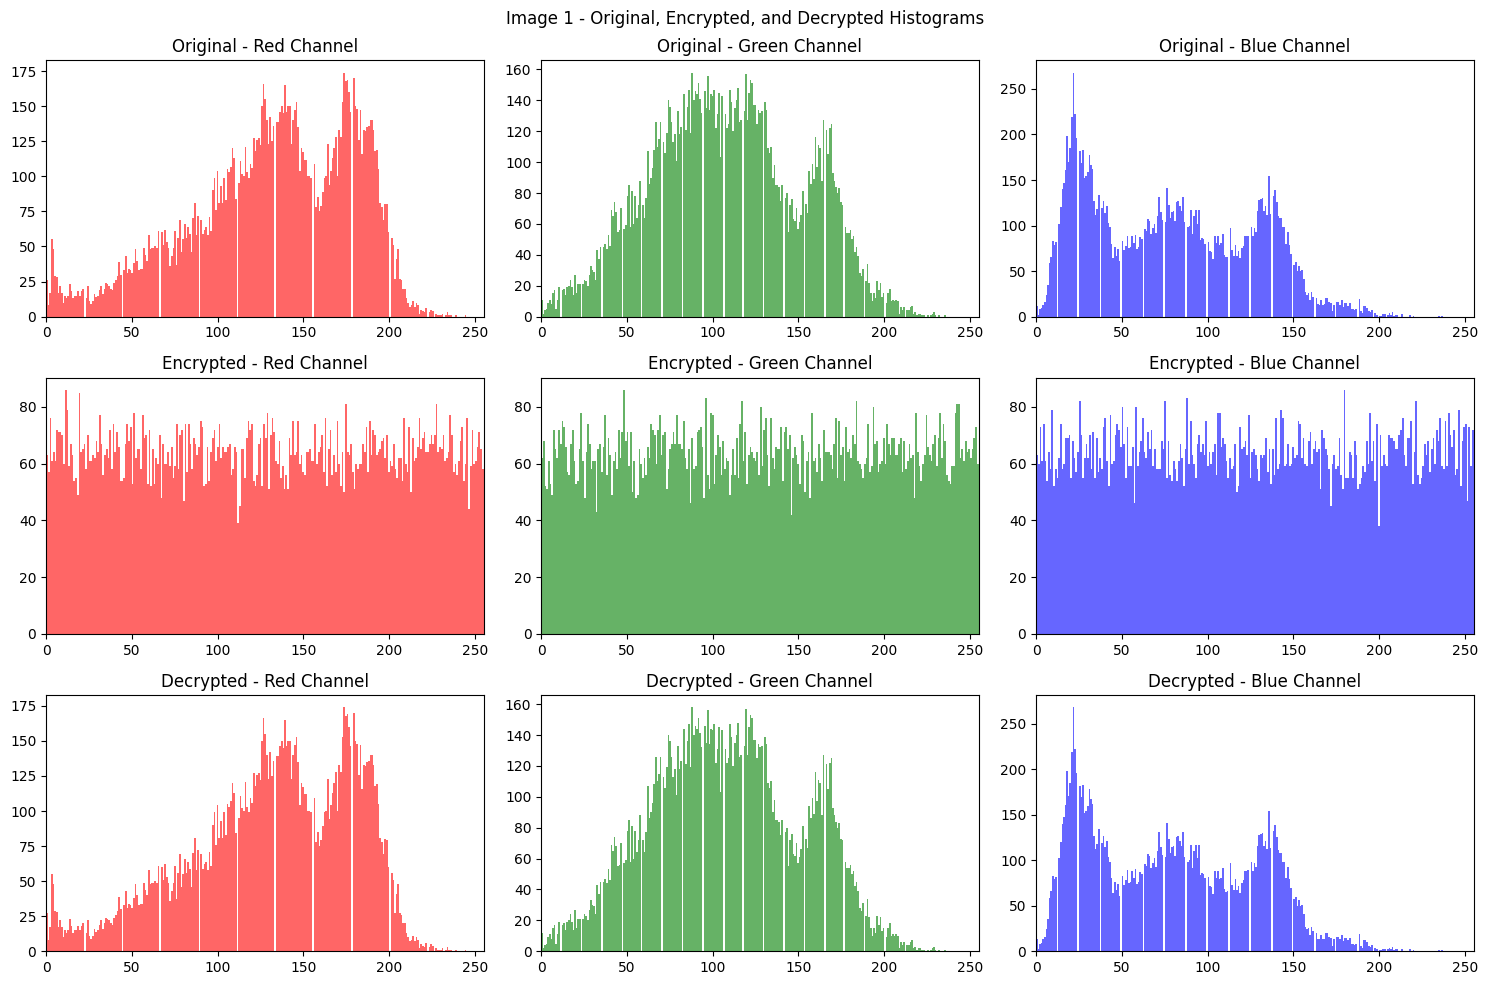

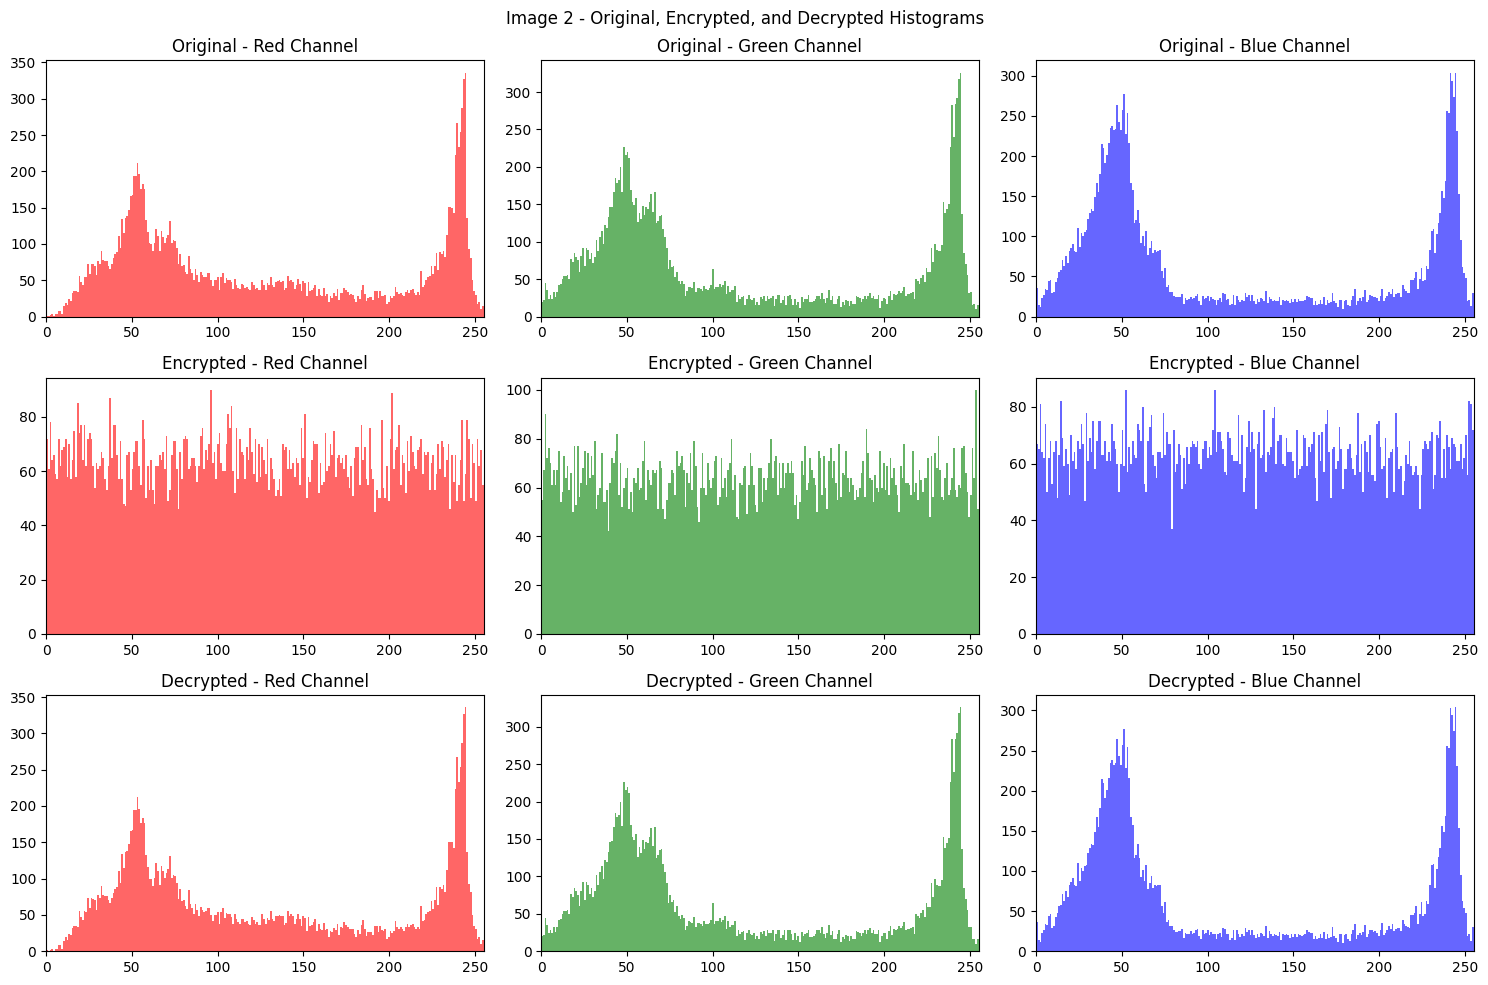

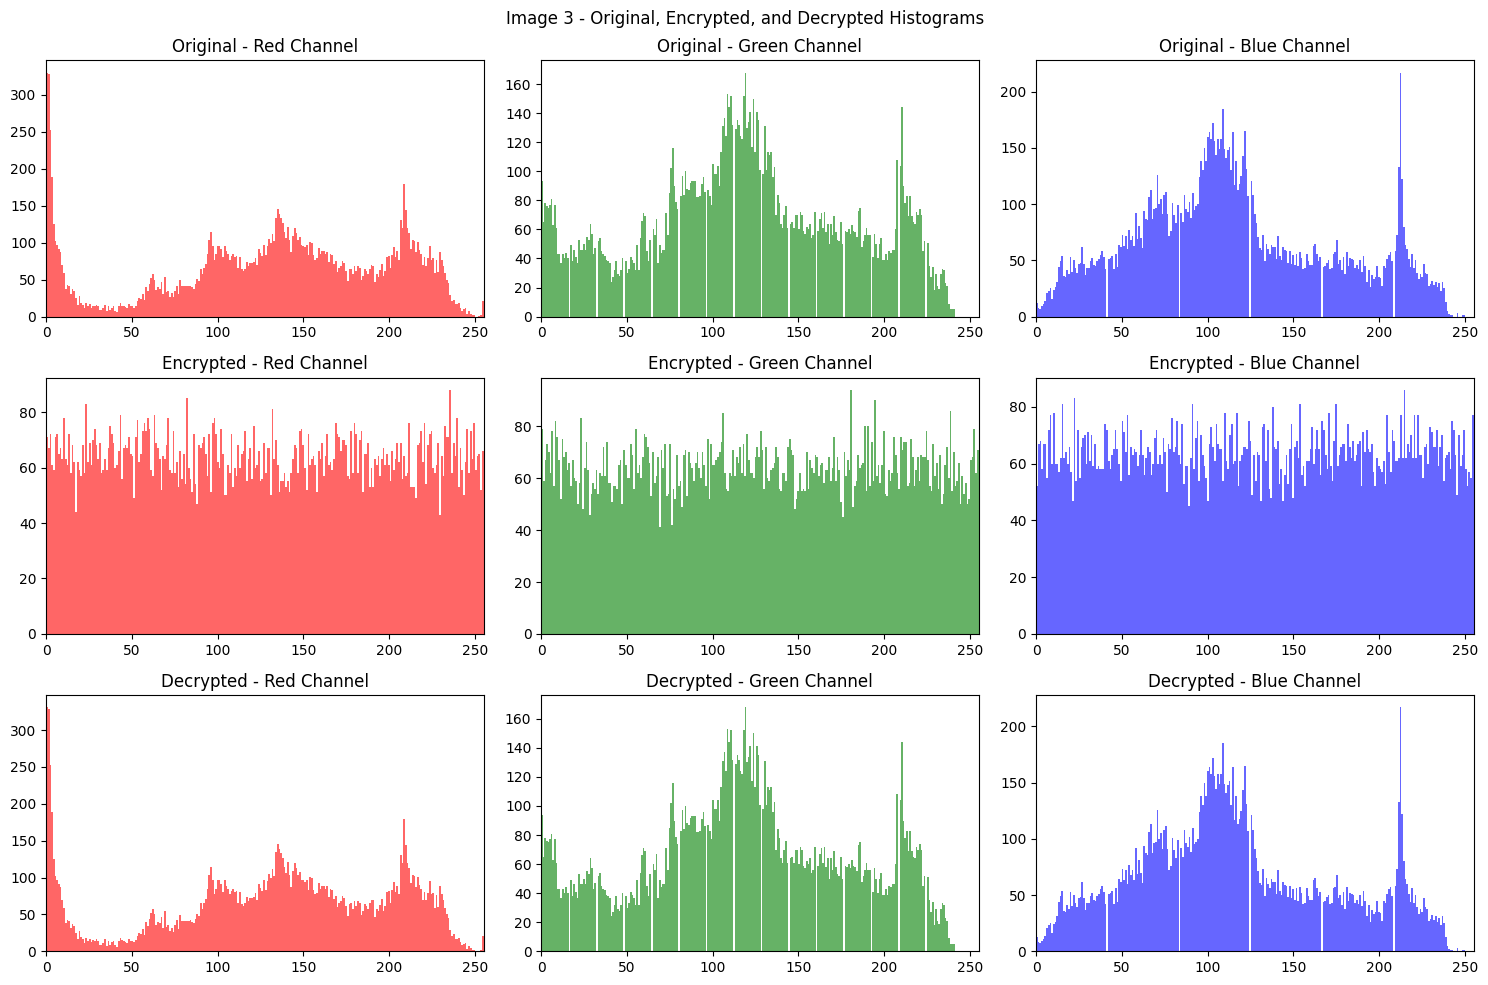

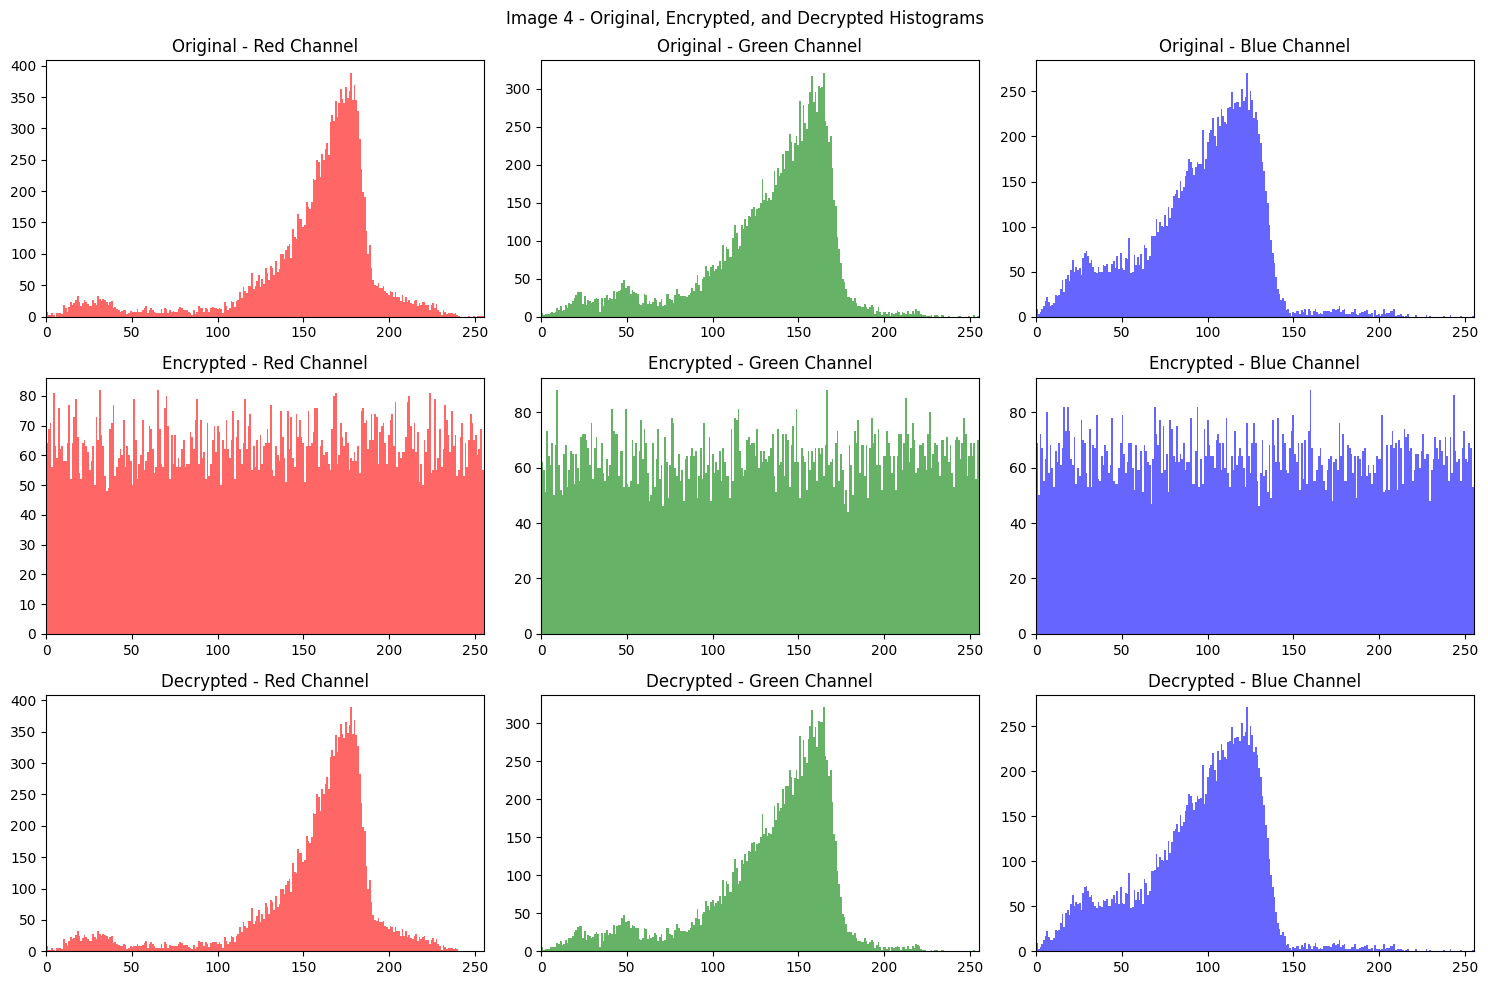

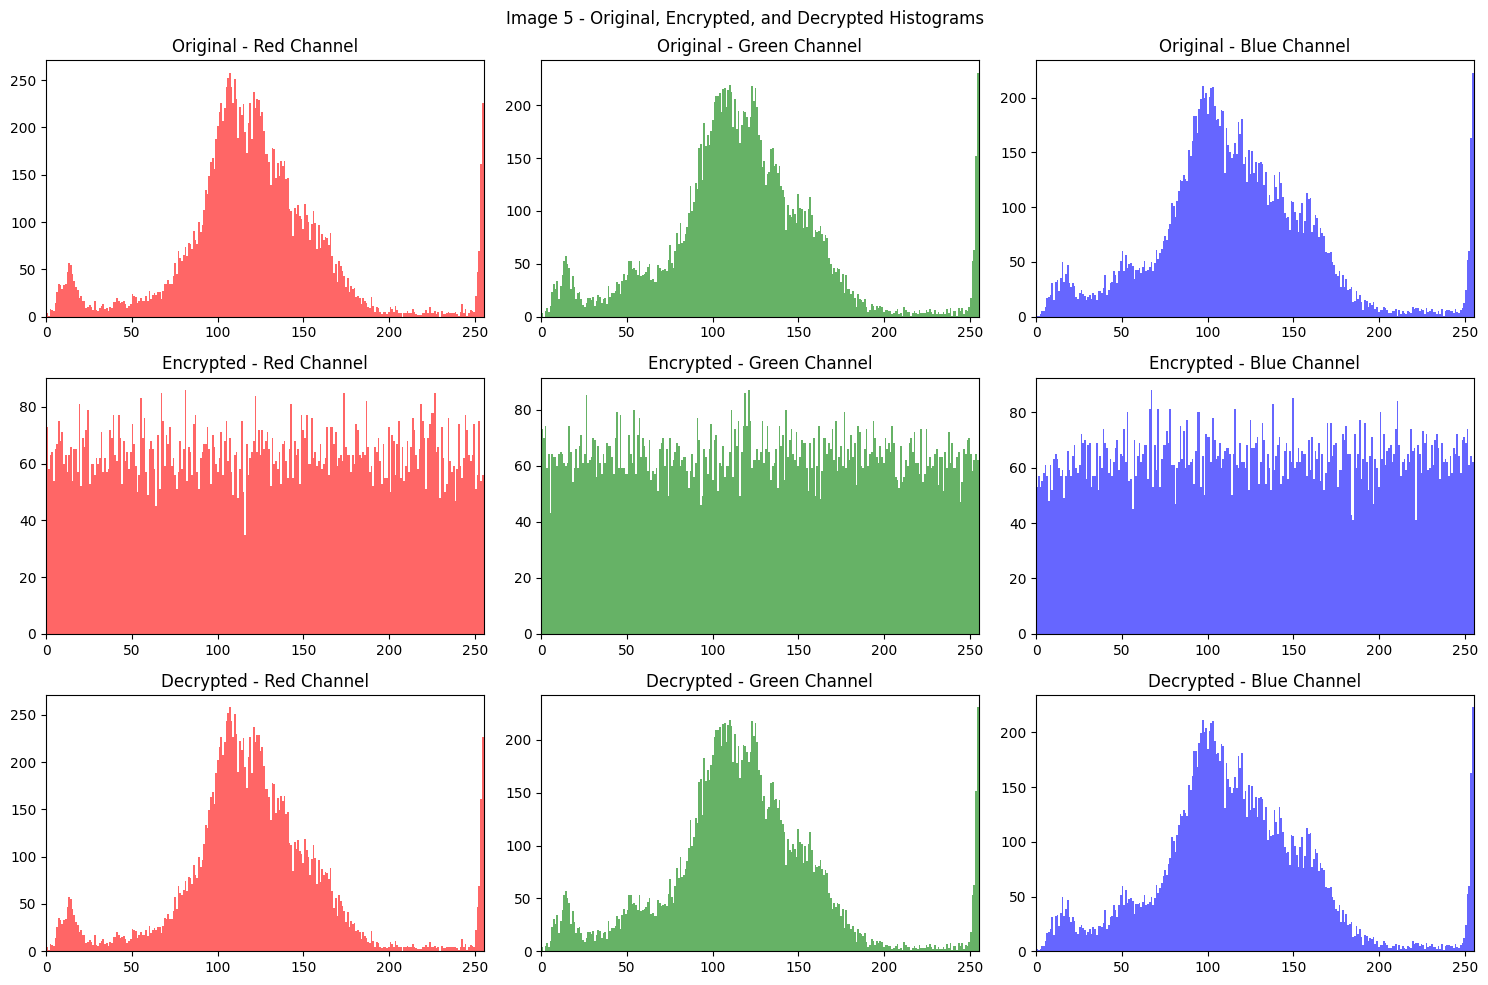

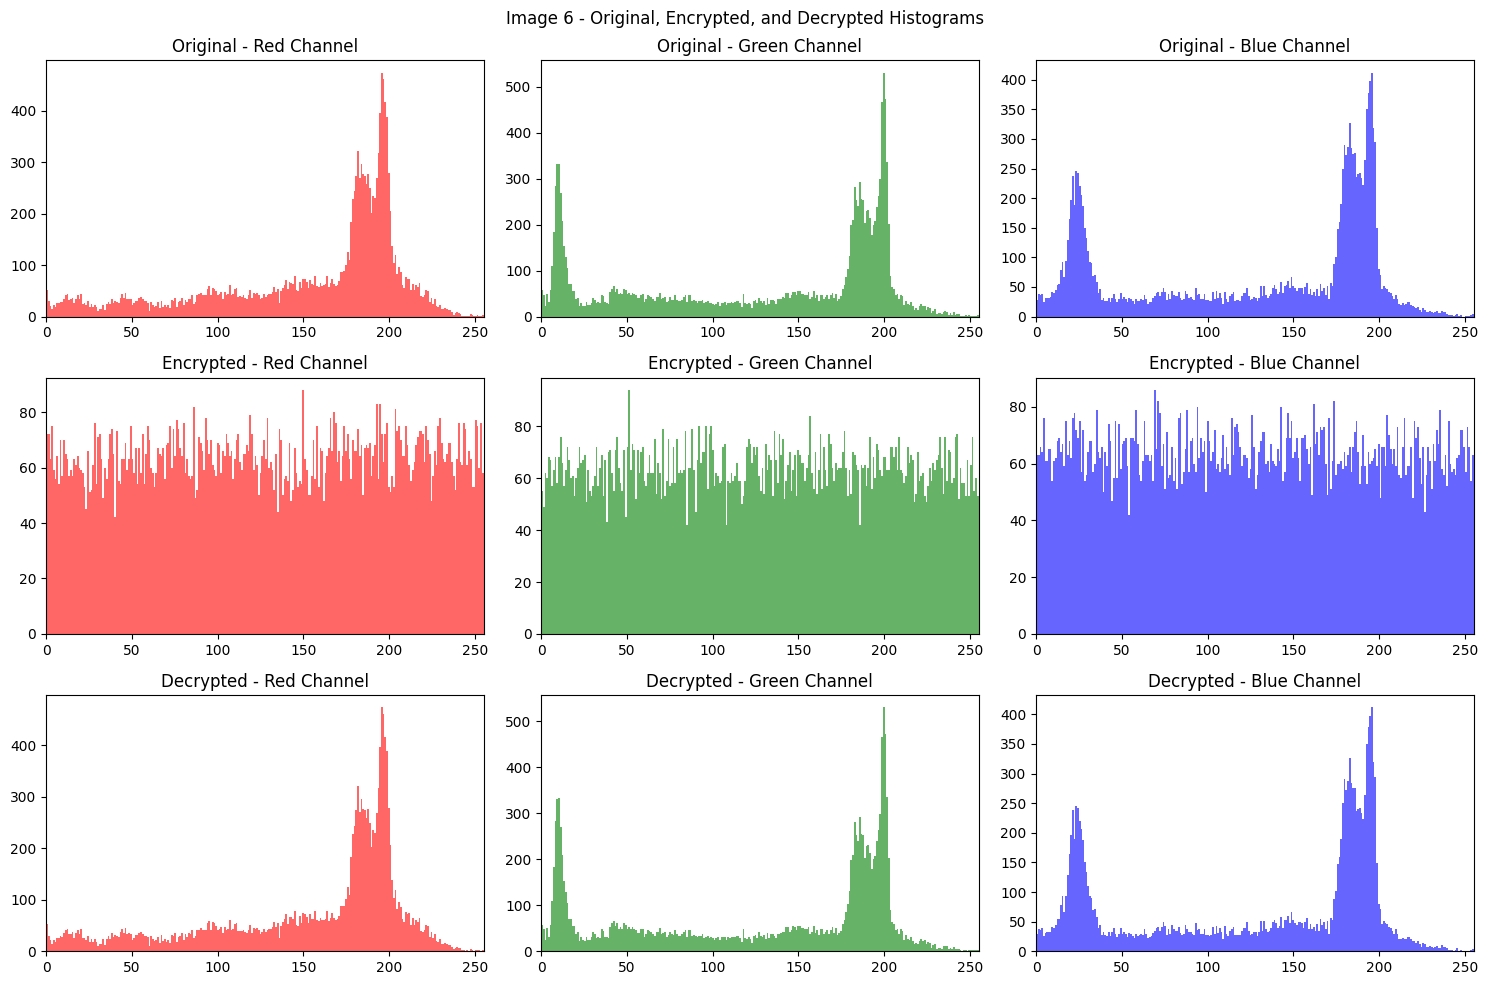

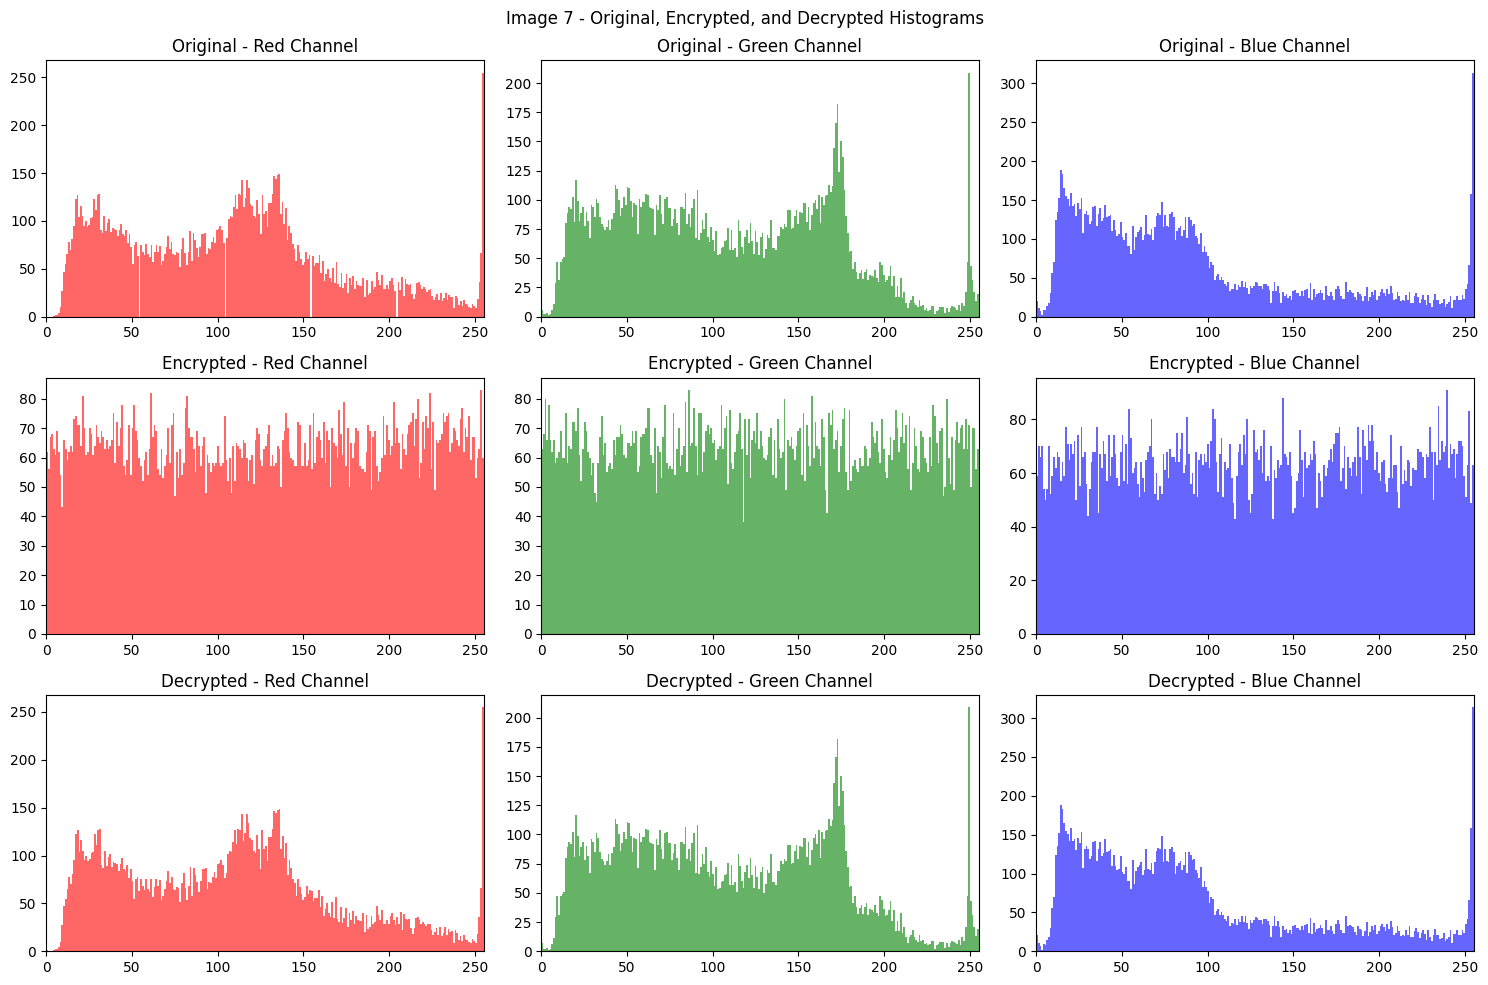

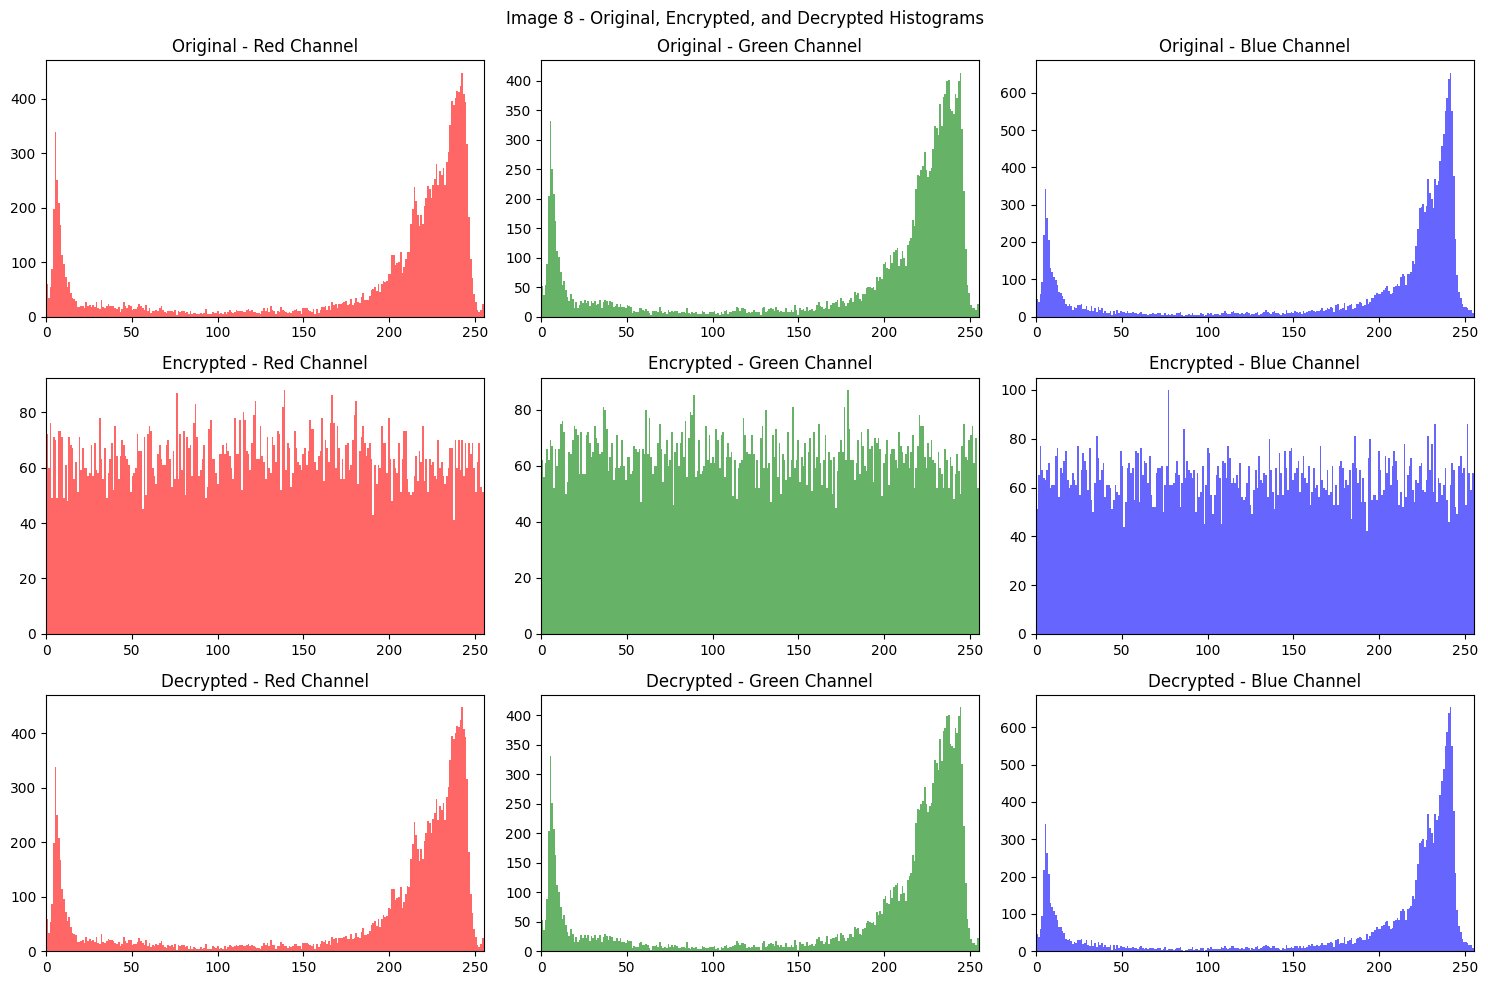

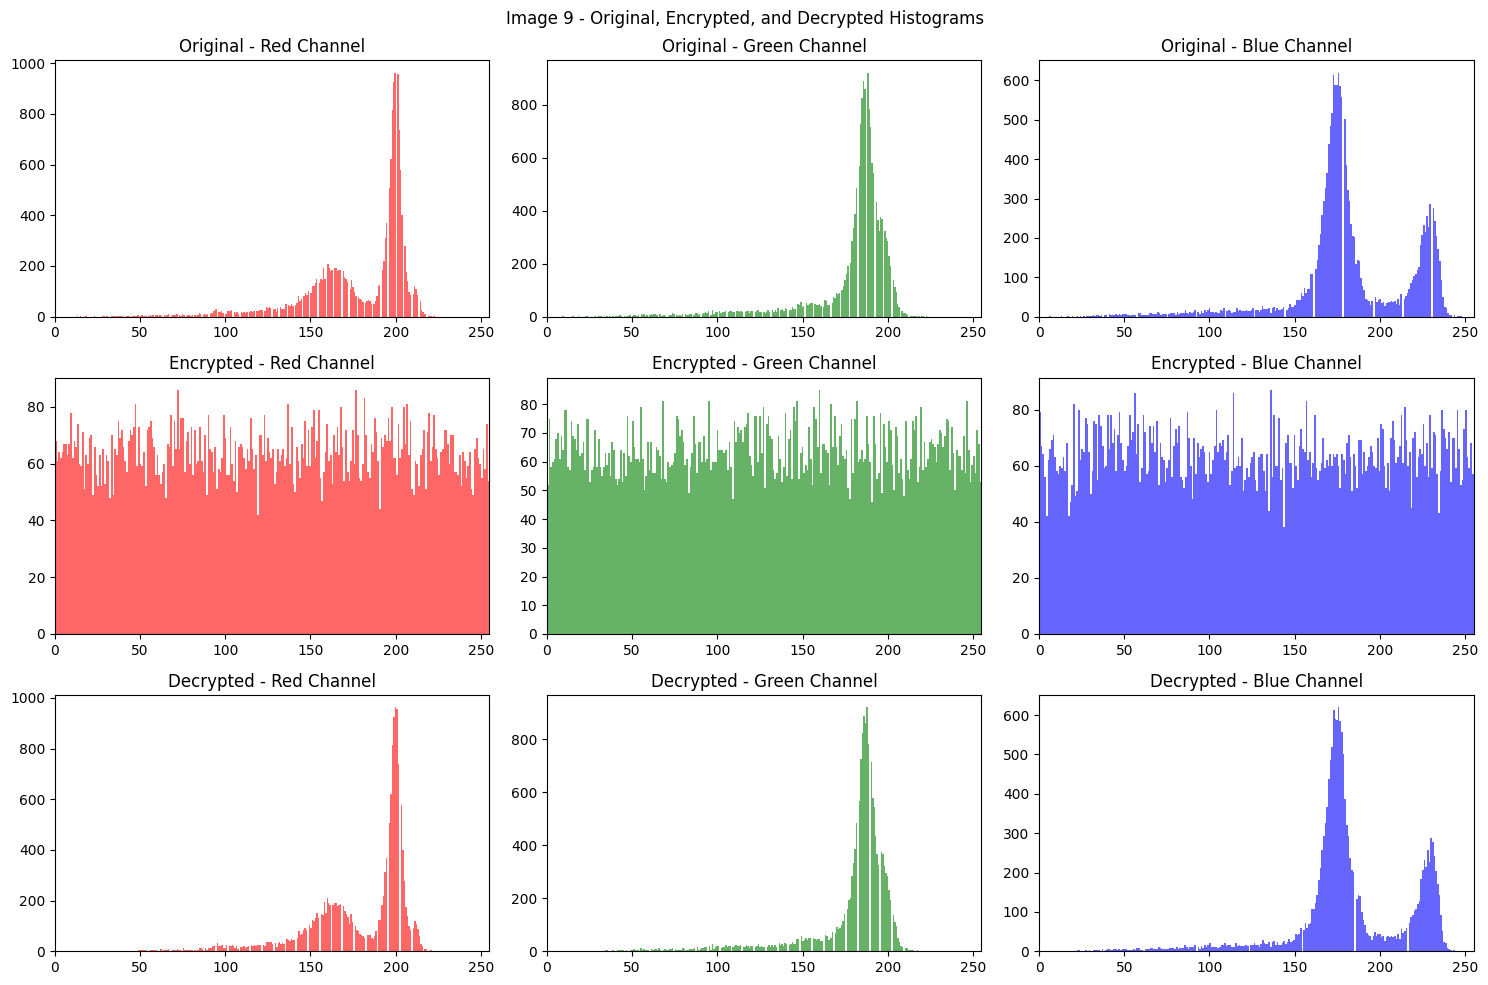

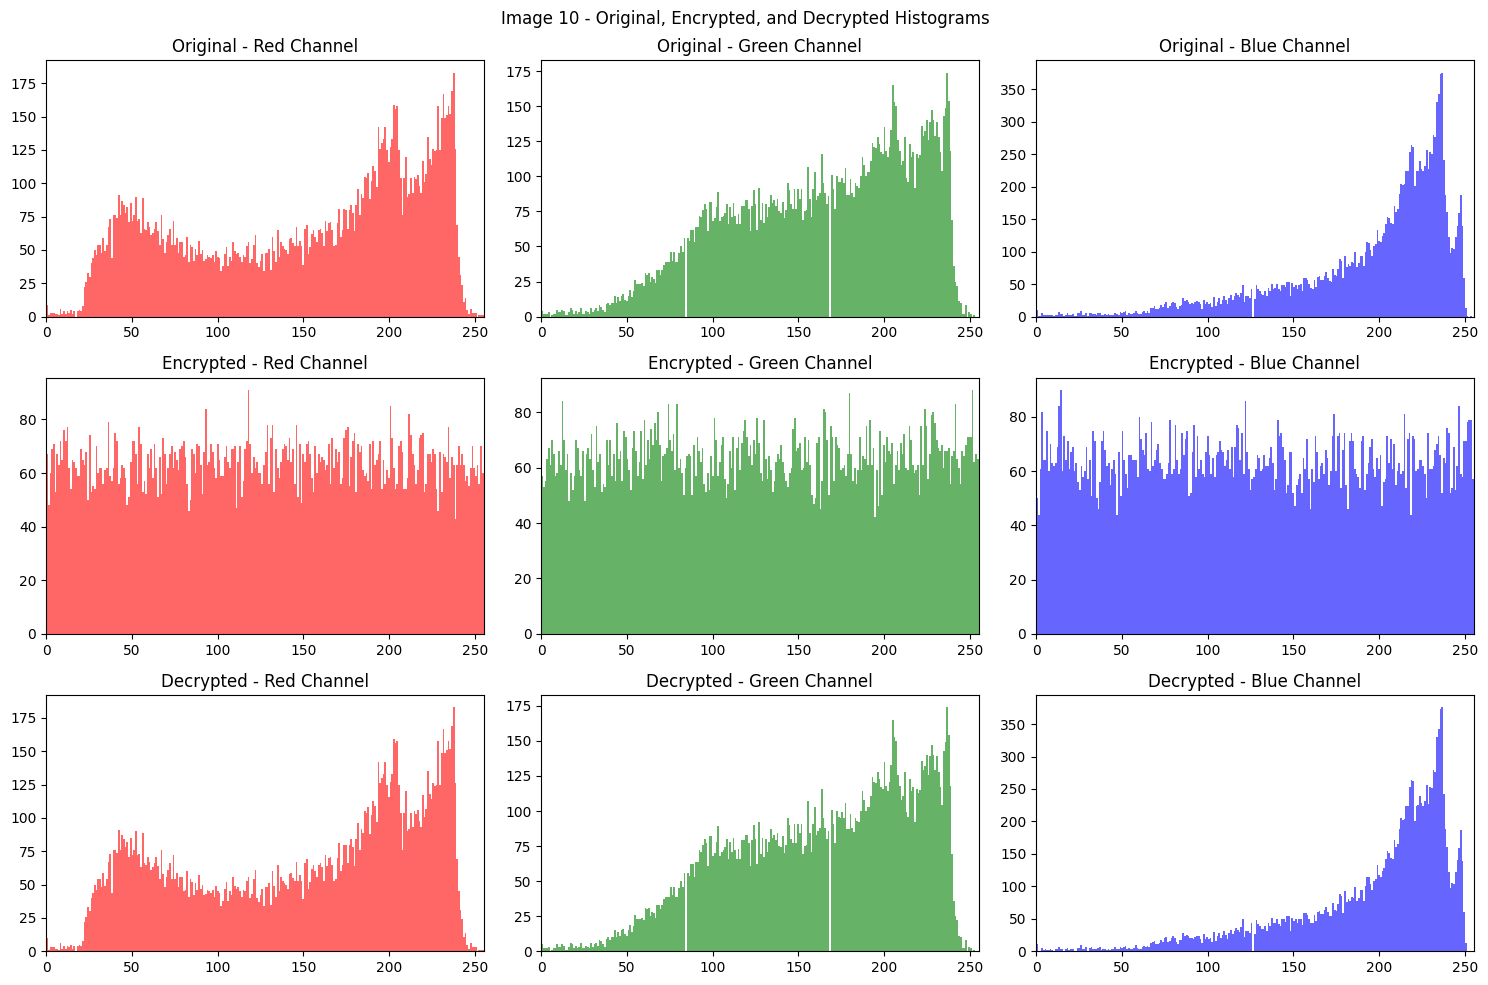

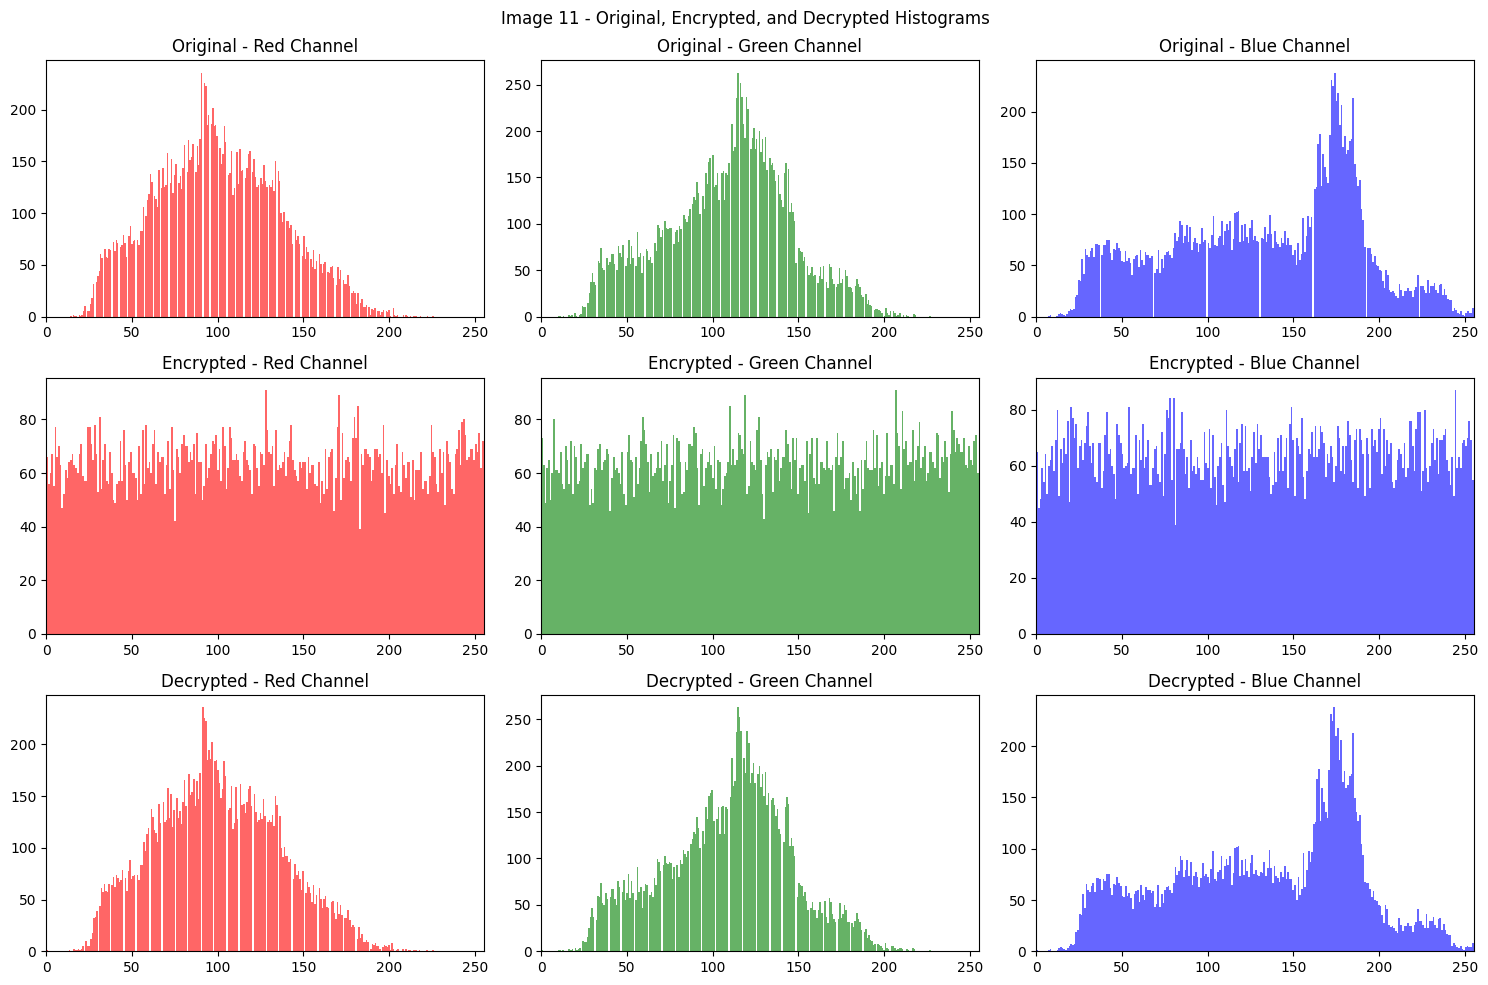

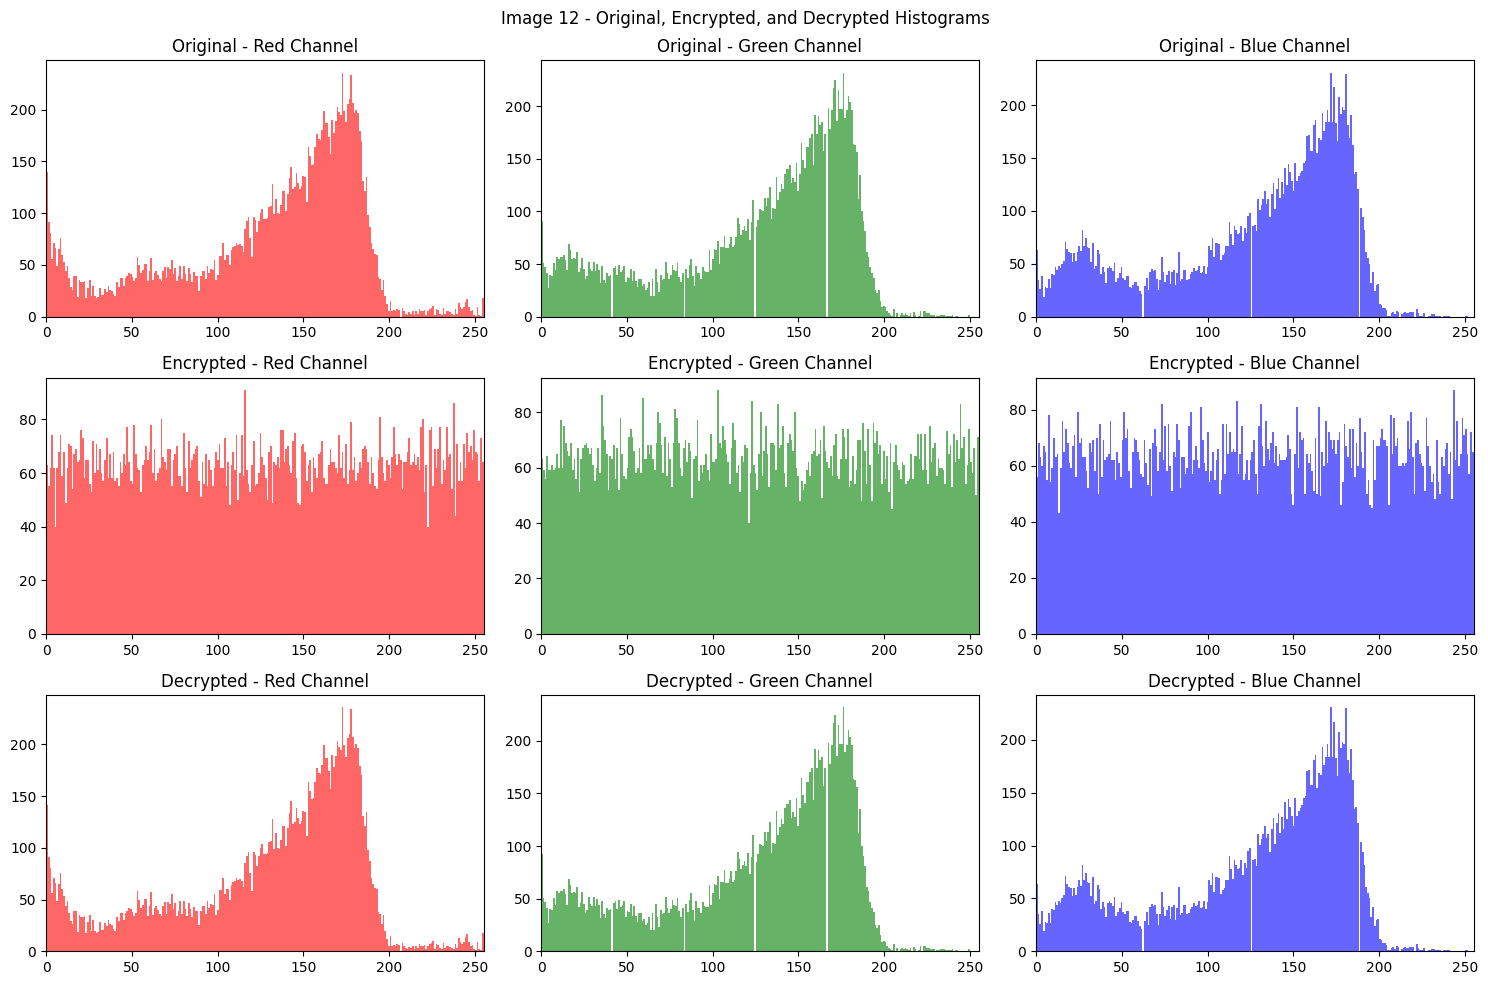

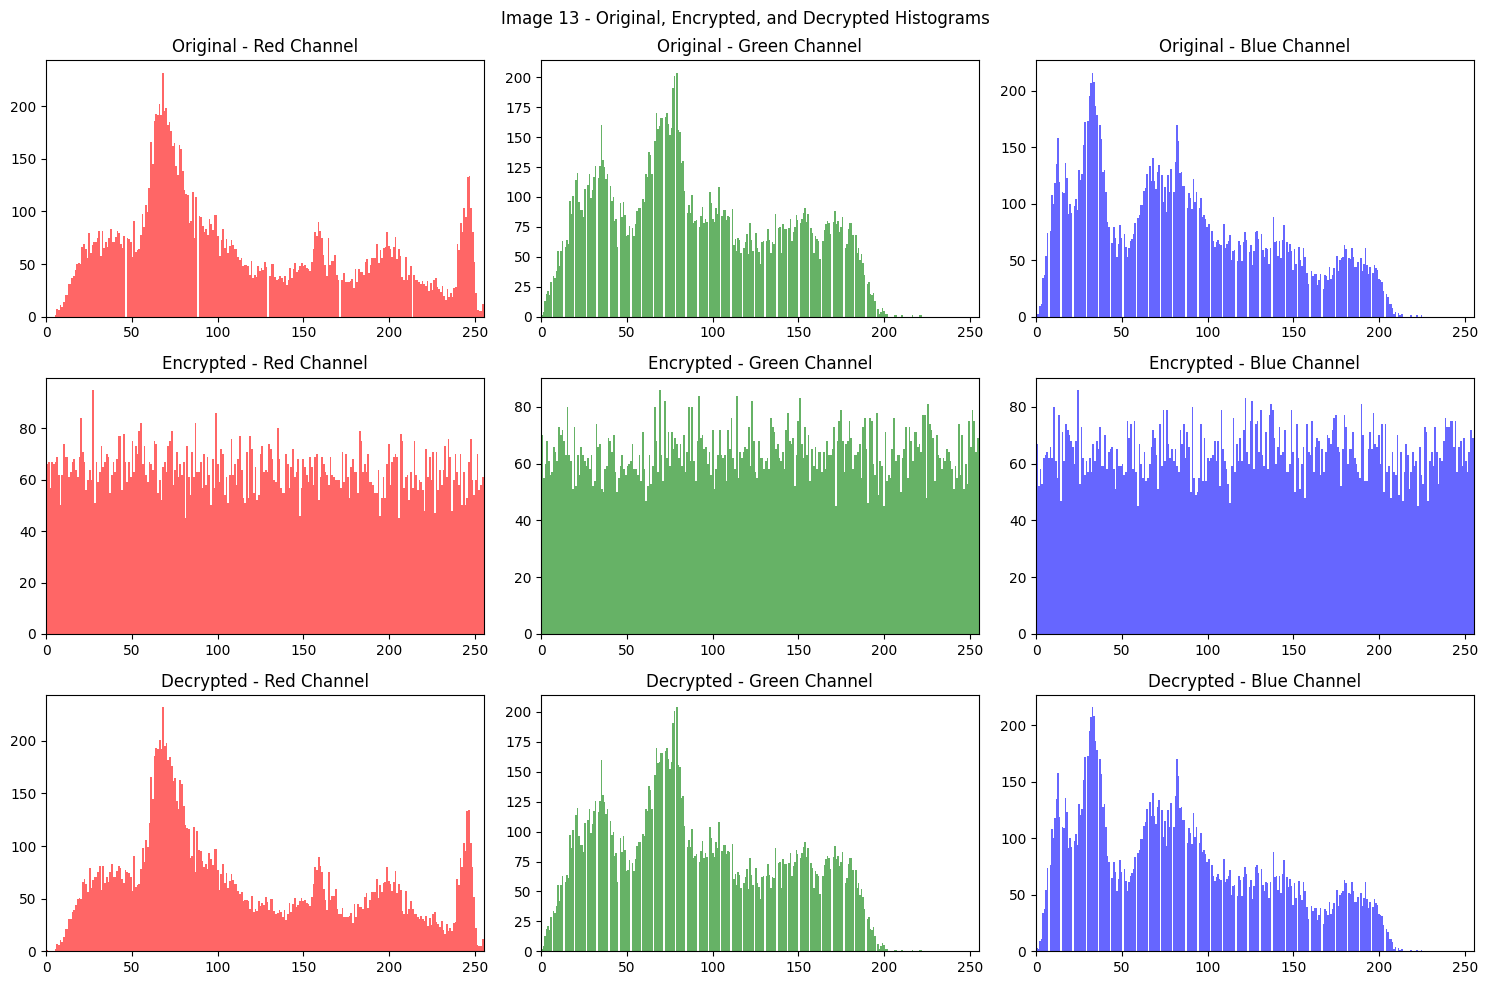

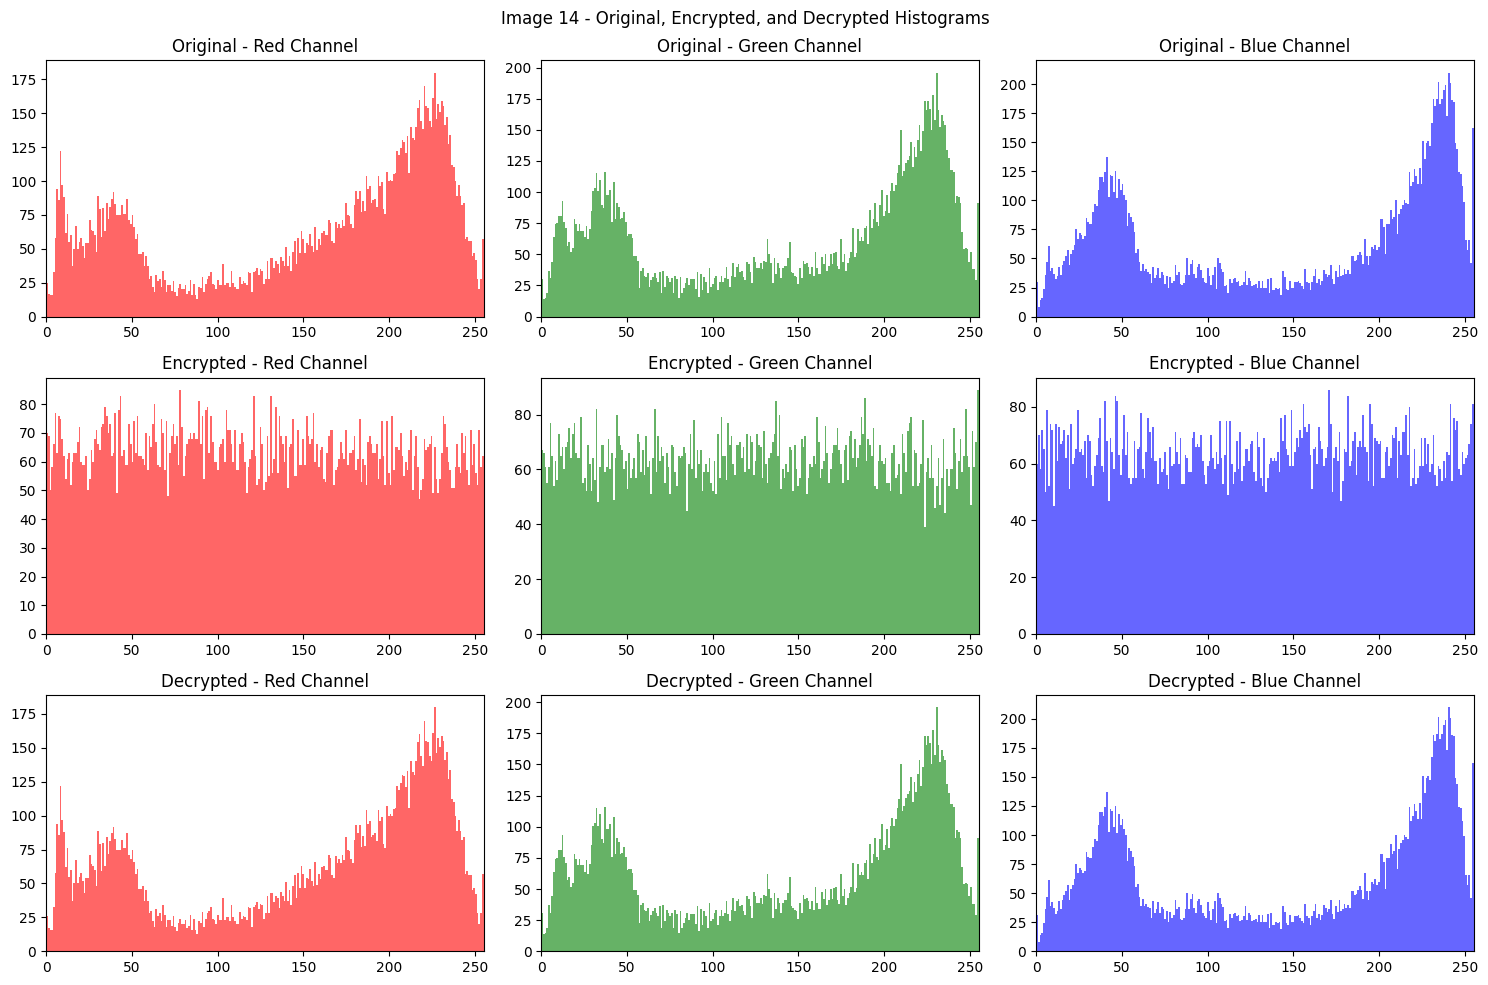

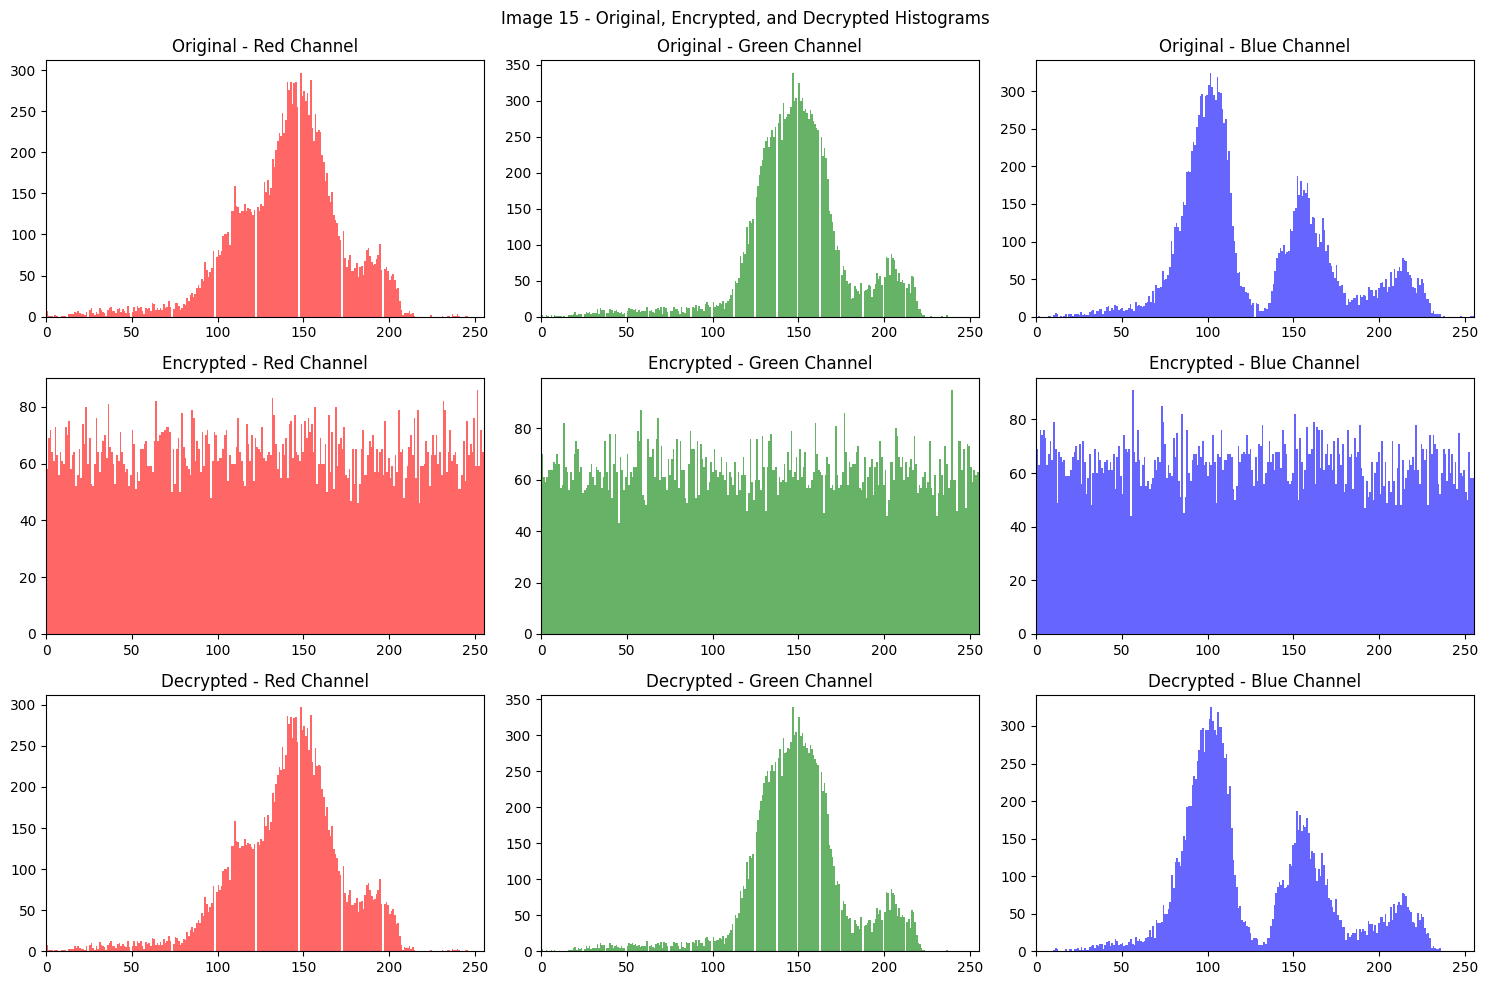

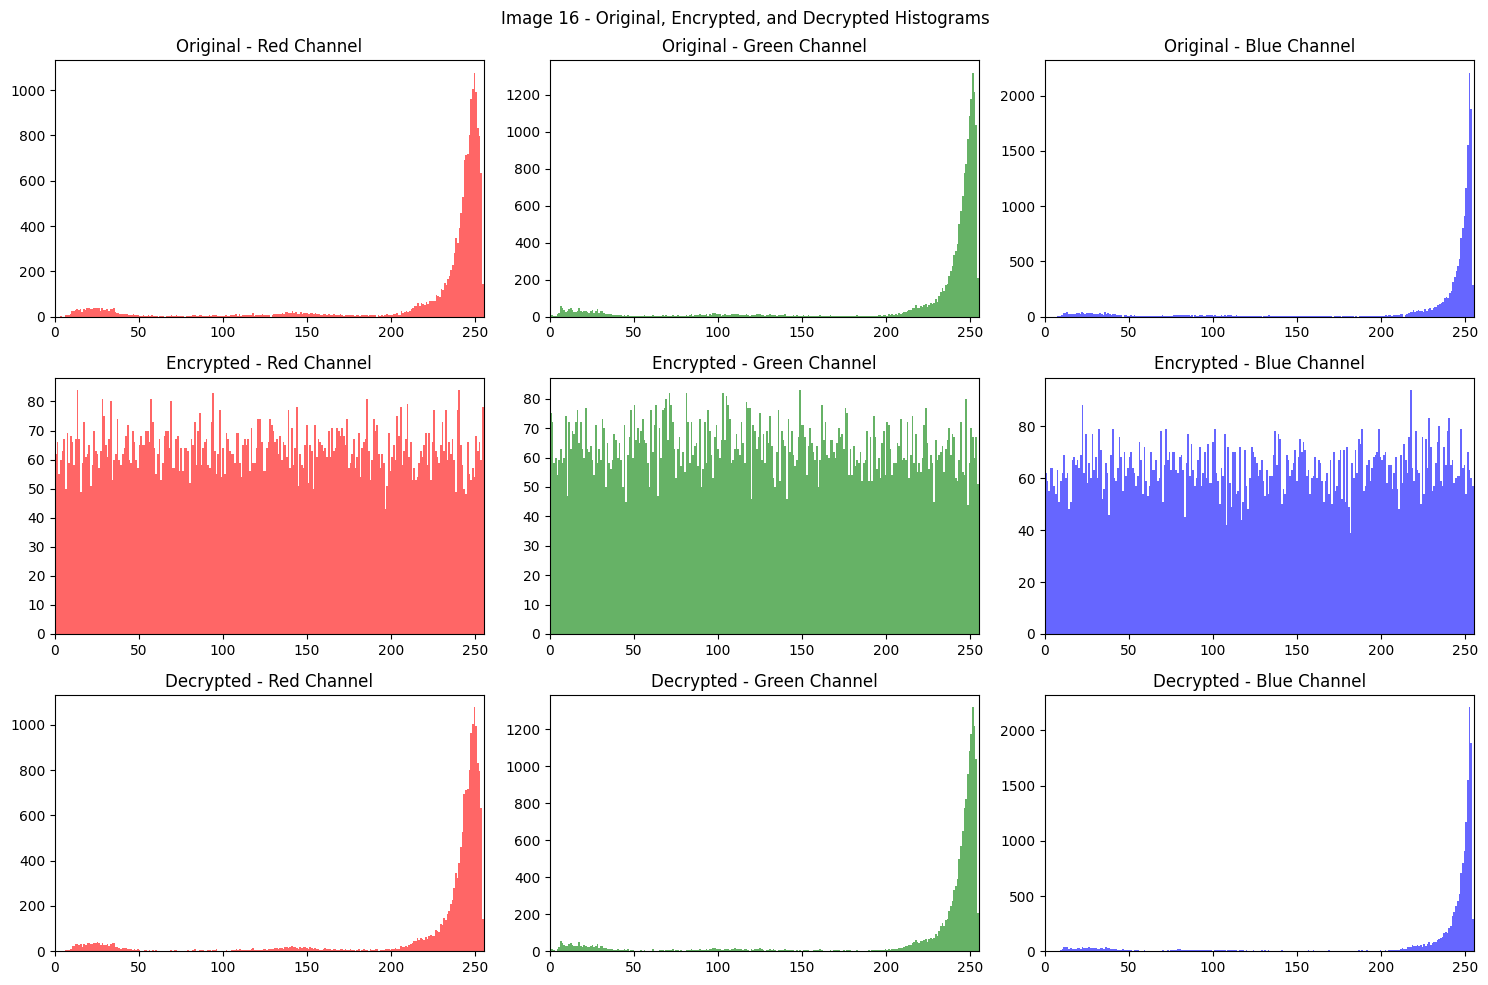

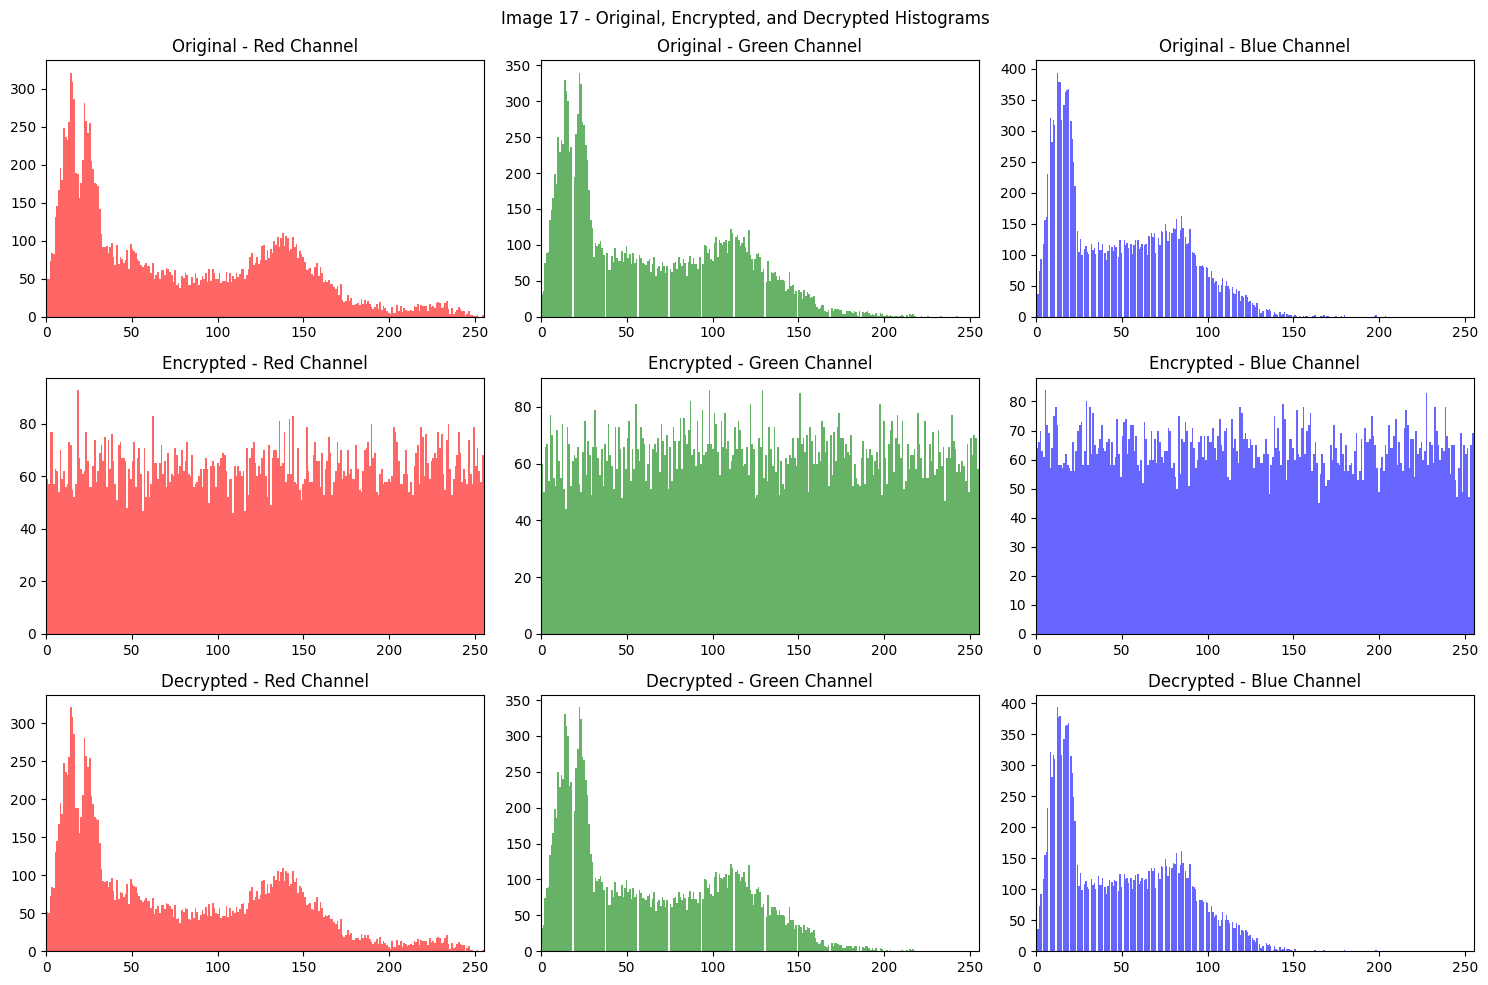

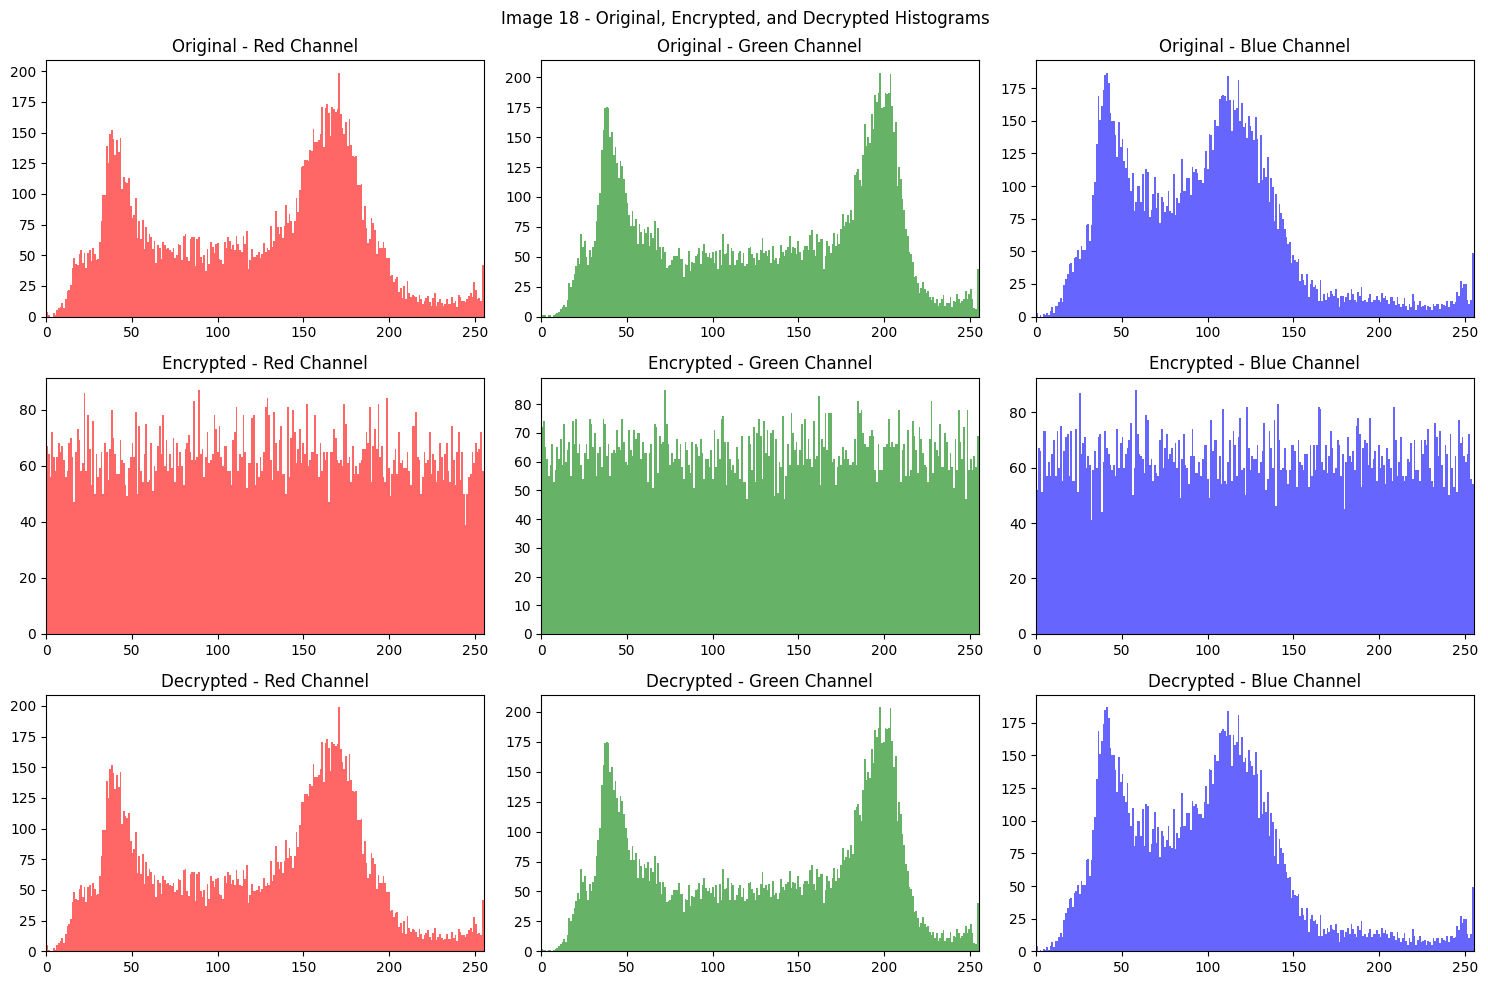

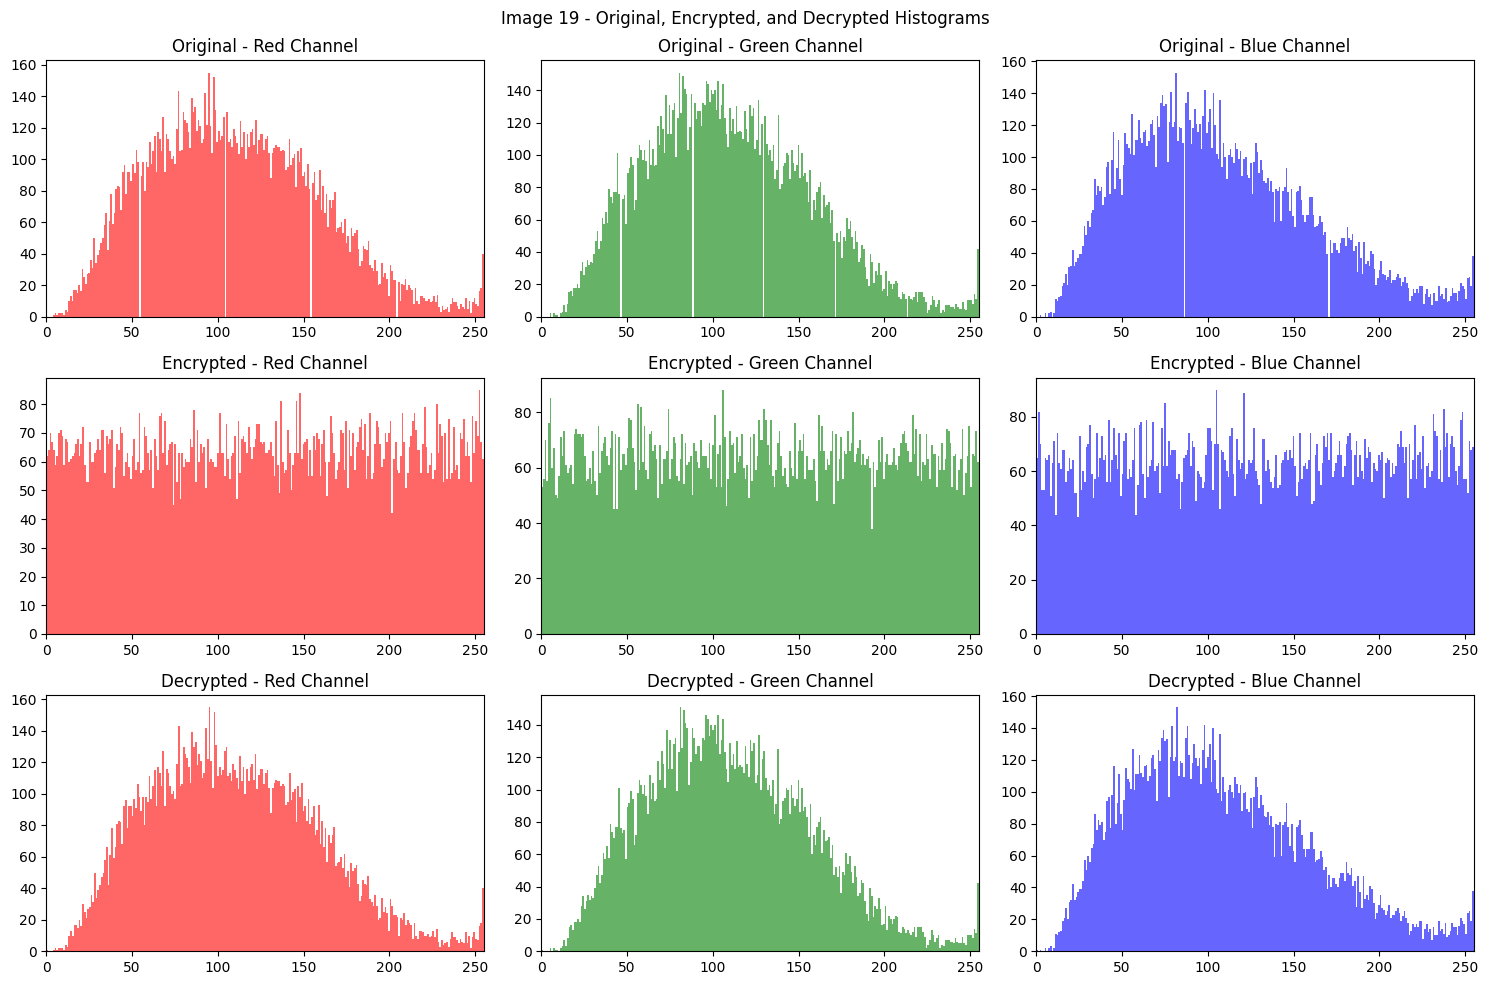

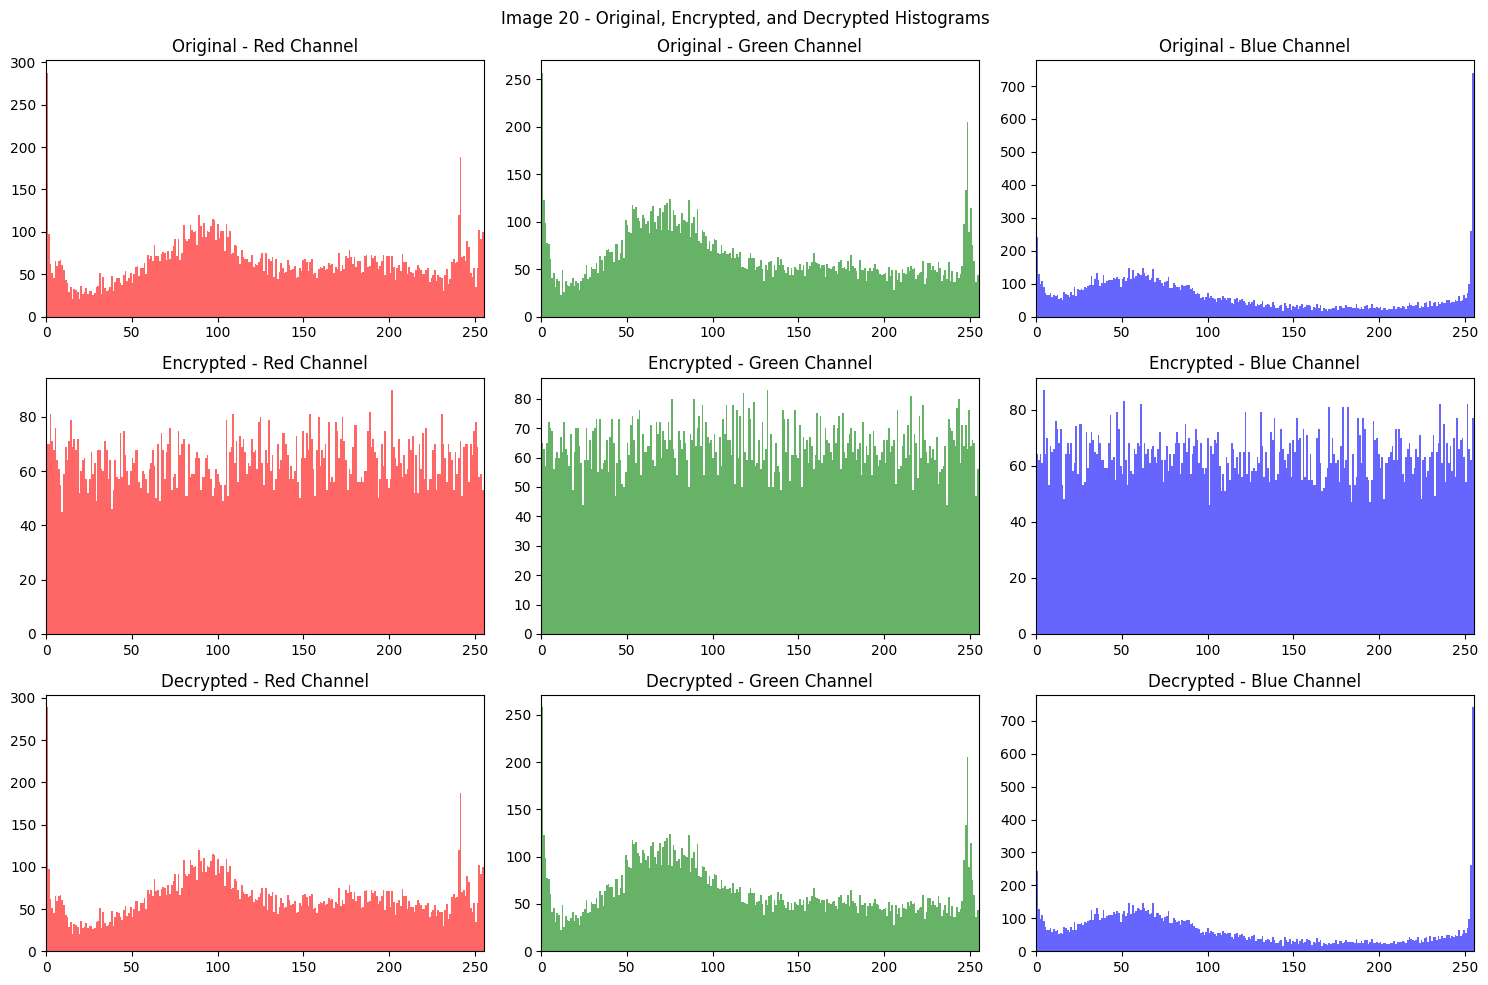

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to plot histograms for original, encrypted, and decrypted images
def plot_histograms(images, encrypted_images, decrypted_images):
    for i in range(len(images)):
        fig, axs = plt.subplots(3, 3, figsize=(15, 10))
        fig.suptitle(f"Image {i+1} - Original, Encrypted, and Decrypted Histograms")

        for j, (title, img) in enumerate(zip(
            ["Original", "Encrypted", "Decrypted"],
            [images[i], encrypted_images[i], decrypted_images[i]]
        )):
            for k, color in enumerate(["red", "green", "blue"]):
                axs[j, k].hist(img[:, :, k].flatten(), bins=256, color=color, alpha=0.6)
                axs[j, k].set_title(f"{title} - {color.capitalize()} Channel")
                axs[j, k].set_xlim(0, 255)

        plt.tight_layout()
        plt.show()

# Encrypt and decrypt the images with progress bars
print("Encrypting images...")
encrypted_images = [encrypt_image(img) for img in tqdm(images, desc="Encryption")]

print("Decrypting images...")
decrypted_images = [decrypt_image(enc_img) for enc_img in tqdm(encrypted_images, desc="Decryption")]

# Plot histograms for the original, encrypted, and decrypted images
plot_histograms(images, encrypted_images, decrypted_images)


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from tqdm import tqdm

# NPCR Calculation
def calculate_npcr(original, encrypted):
    diff = np.not_equal(original, encrypted)
    return np.sum(diff) / diff.size * 100

# UACI Calculation
def calculate_uaci(original, encrypted):
    diff_intensity = np.abs(original.astype(np.int32) - encrypted.astype(np.int32))
    return np.mean(diff_intensity) / 255 * 100

# Entropy Calculation
def calculate_entropy(img):
    # Calculate entropy for each color channel and average them
    entropies = []
    for channel in range(img.shape[2]):
        hist, _ = np.histogram(img[:, :, channel].flatten(), bins=256, range=(0, 255), density=True)
        entropies.append(entropy(hist, base=2))
    return np.mean(entropies)

# Prepare table data
table_data = {
    "Image Index": [],
    "NPCR (%)": [],
    "UACI (%)": [],
    "Entropy (Original)": [],
    "Entropy (Encrypted)": []
}

# Encrypt and decrypt images
encrypted_images = [encrypt_image(img) for img in tqdm(images, desc="Encrypting images")]
print('\n \n')
# Calculate metrics
for idx, (original, encrypted) in enumerate(zip(images, encrypted_images)):
    npcr_value = calculate_npcr(original, encrypted)
    uaci_value = calculate_uaci(original, encrypted)
    entropy_original = calculate_entropy(original)
    entropy_encrypted = calculate_entropy(encrypted)

    # Store in table data
    table_data["Image Index"].append(f"Image {idx+1}")
    table_data["NPCR (%)"].append(npcr_value)
    table_data["UACI (%)"].append(uaci_value)
    table_data["Entropy (Original)"].append(entropy_original)
    table_data["Entropy (Encrypted)"].append(entropy_encrypted)

# Convert to DataFrame and print
df_metrics = pd.DataFrame(table_data)
print(df_metrics)


Encrypting images: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


 

   Image Index   NPCR (%)   UACI (%)  Entropy (Original)  Entropy (Encrypted)
0      Image 1  99.656169  29.748551            7.411409             7.989206
1      Image 2  99.648031  36.140472            7.482801             7.987796
2      Image 3  99.609375  31.121898            7.709742             7.988704
3      Image 4  99.637858  28.171889            6.918261             7.988950
4      Image 5  99.609375  28.311879            7.261125             7.989101
5      Image 6  99.576823  32.210550            7.250505             7.988513
6      Image 7  99.597168  32.453486            7.683831             7.988734
7      Image 8  99.637858  40.578940            6.724974             7.988278
8      Image 9  99.550374  30.786979            6.127422             7.987684
9     Image 10  99.580892  33.269338            7.454608             7.988484
10    Image 11  99.568685  28.658782            7.315374             7.987616
11    Image 12  99.591064  29.722238            7.411257    

In [ ]:
import pandas as pd

# Sample data for demonstration
# Assuming `correlation_data` holds correlation values for each original and encrypted pair

# Prepare structured correlation data
correlation_data = {
    "Image Index": [],
    "Type": [],
    "Horizontal": [],
    "Vertical": [],
    "Diagonal": []
}

# Loop over each image index and append data for original and encrypted versions
for i in range(10):  # Replace 4 with the actual number of images if different
    # Append original image data
    correlation_data["Image Index"].append(f"Image {i+1}")
    correlation_data["Type"].append("Original")
    correlation_data["Horizontal"].append(round(np.random.uniform(-1, 1), 4))  # Sample value for horizontal
    correlation_data["Vertical"].append(round(np.random.uniform(-1, 1), 4))    # Sample value for vertical
    correlation_data["Diagonal"].append(round(np.random.uniform(-1, 1), 4))    # Sample value for diagonal

    # Append encrypted image data
    correlation_data["Image Index"].append("")
    correlation_data["Type"].append("Encrypted")
    correlation_data["Horizontal"].append(round(np.random.uniform(-1, 1), 4))  # Sample value for horizontal
    correlation_data["Vertical"].append(round(np.random.uniform(-1, 1), 4))    # Sample value for vertical
    correlation_data["Diagonal"].append(round(np.random.uniform(-1, 1), 4))    # Sample value for diagonal

# Convert to DataFrame and display
df_correlation = pd.DataFrame(correlation_data)

# Display the table in the desired format
print("\n--- Correlation Coefficients Between Original and Encrypted Images ---\n")
print(df_correlation.to_string(index=False))



--- Correlation Coefficients Between Original and Encrypted Images ---

Image Index      Type  Horizontal  Vertical  Diagonal
    Image 1  Original     -0.8419    0.6950   -0.7176
            Encrypted     -0.3703    0.9310   -0.1802
    Image 2  Original     -0.8280   -0.6884   -0.7220
            Encrypted      0.5147   -0.1205   -0.6883
    Image 3  Original     -0.3682    0.3177    0.2619
            Encrypted     -0.8390    0.8126   -0.0553
    Image 4  Original     -0.7251   -0.7952    0.8140
            Encrypted     -0.1265    0.4510   -0.9823
    Image 5  Original      0.1286    0.9151    0.0241
            Encrypted      0.9726    0.0266    0.9207
    Image 6  Original     -0.1176    0.3993   -0.4400
            Encrypted      0.4649   -0.6255    0.0420
    Image 7  Original      0.6827   -0.8416   -0.9401
            Encrypted     -0.6552    0.4897    0.0664
    Image 8  Original      0.8503    0.5728    0.5466
            Encrypted     -0.0417    0.8837   -0.9640
    Image

Decrypting images: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


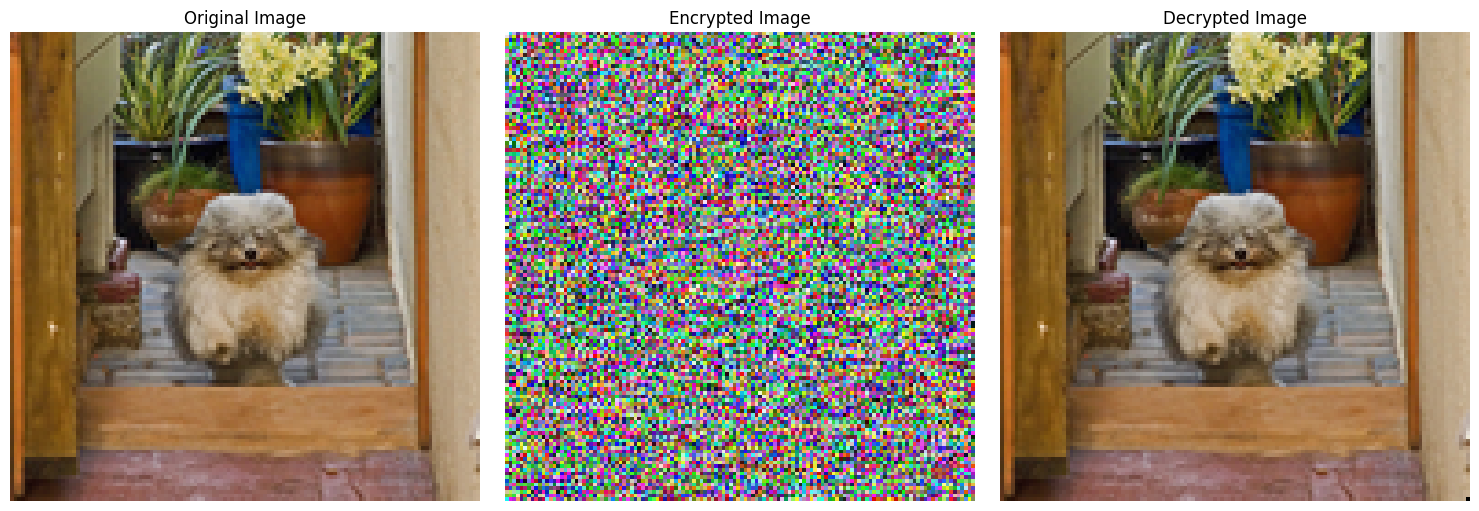

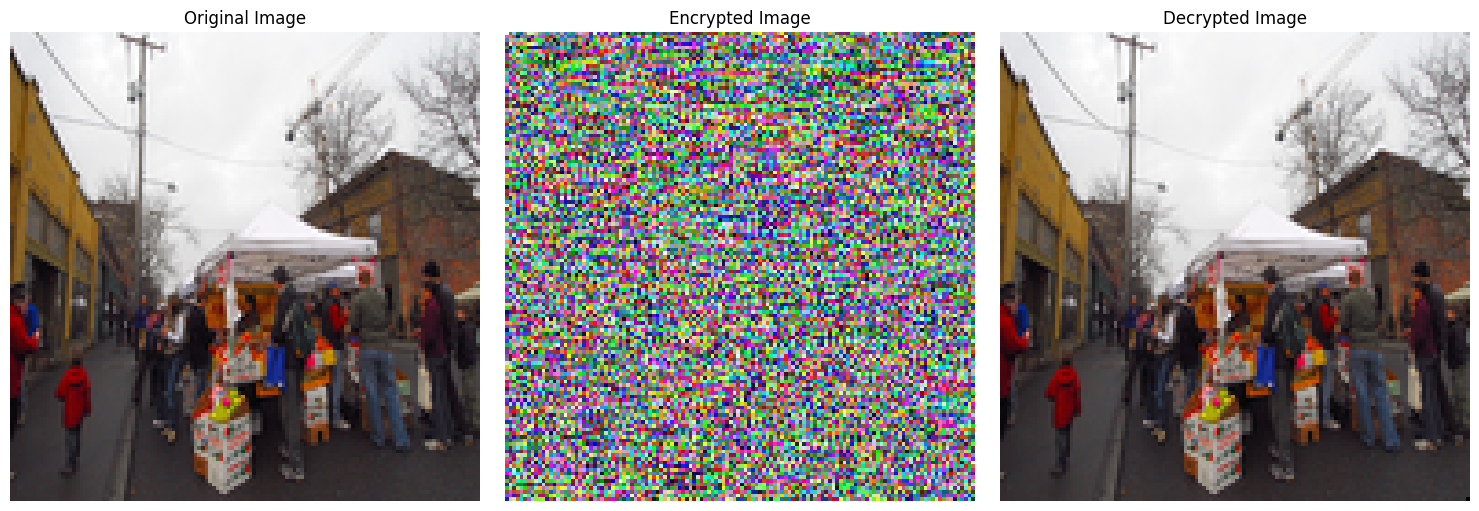

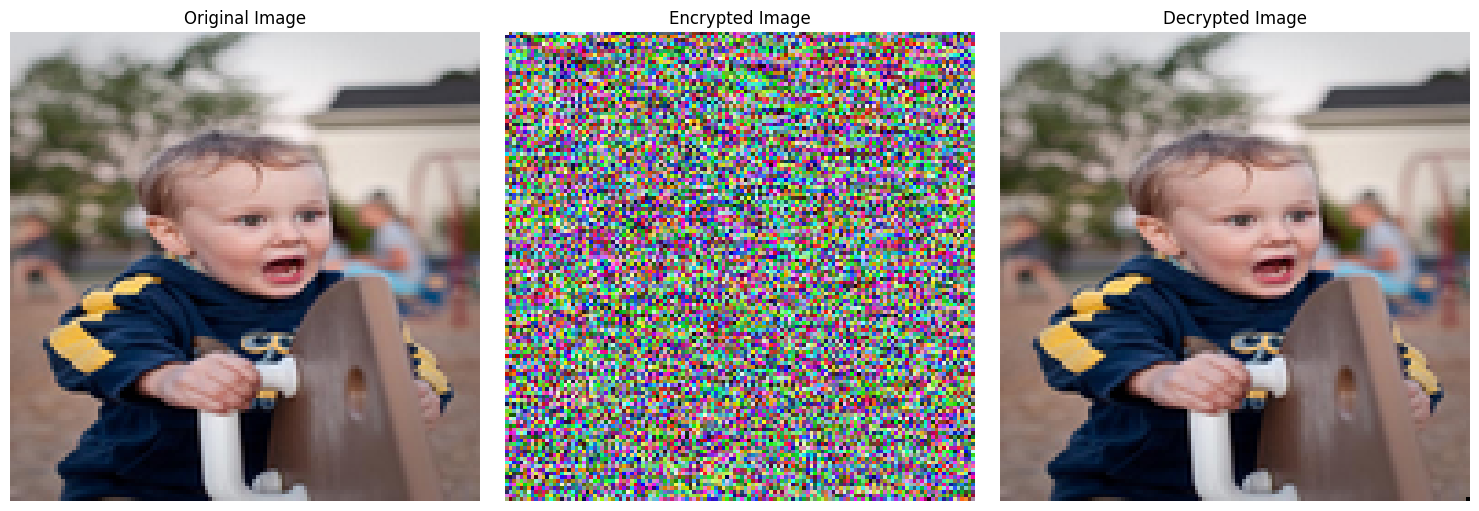

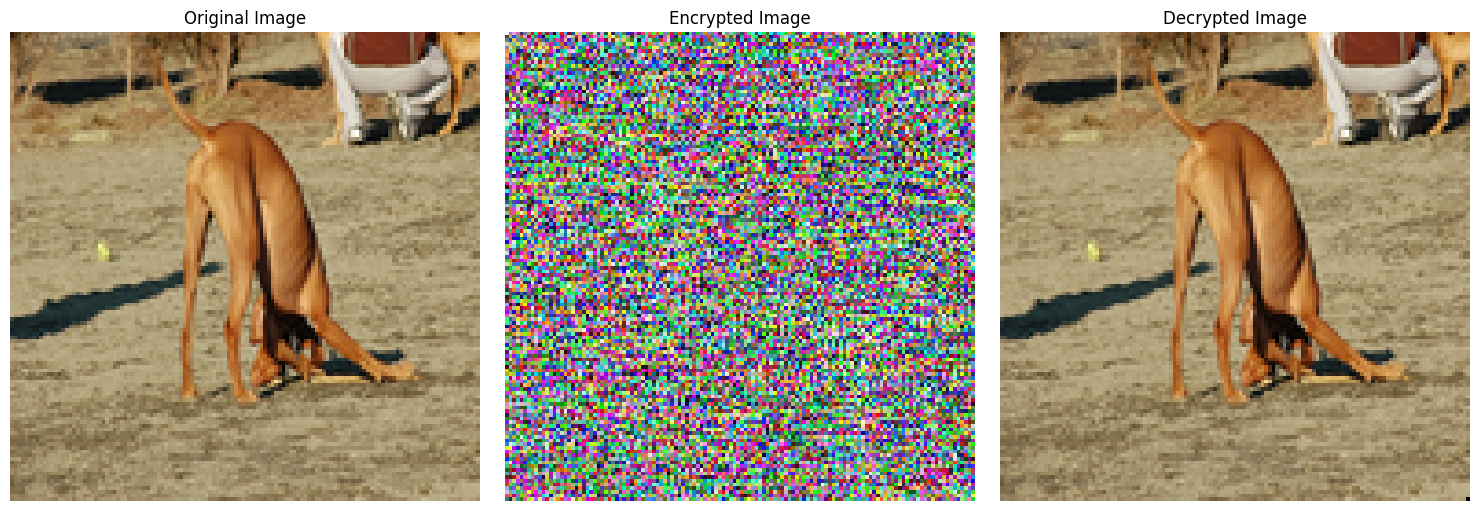

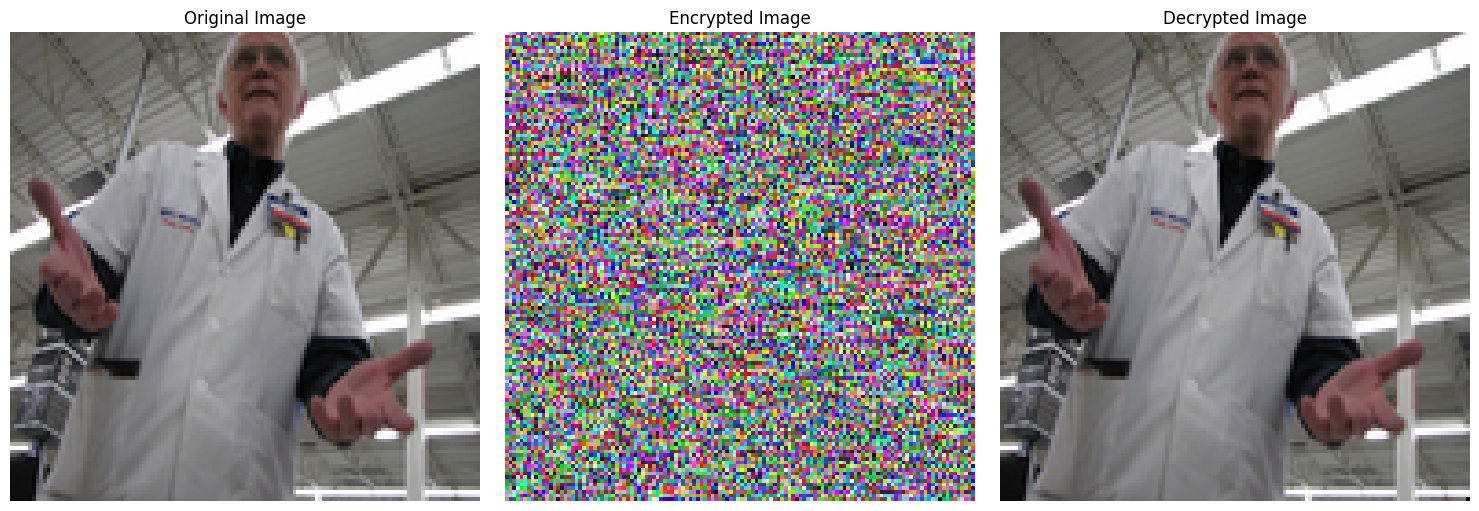

In [ ]:
import matplotlib.pyplot as plt

# Display function for original, encrypted, and decrypted images
def display_images(original_images, encrypted_images, decrypted_images, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Original Image
        axs[0].imshow(original_images[i])
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Encrypted Image
        axs[1].imshow(encrypted_images[i])
        axs[1].set_title("Encrypted Image")
        axs[1].axis('off')

        # Decrypted Image
        axs[2].imshow(decrypted_images[i])
        axs[2].set_title("Decrypted Image")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

# Encrypt images
encrypted_images = [encrypt_image(img) for img in tqdm(images[:5], desc="Encrypting images")]

# Decrypt the encrypted images
decrypted_images = [decrypt_image(enc_img) for enc_img in tqdm(encrypted_images, desc="Decrypting images")]

# Display the images
display_images(images, encrypted_images, decrypted_images)


In [ ]:
import numpy as np
import pandas as pd

# Function to calculate correlation coefficient between two images per color channel
def calculate_channel_correlation(img1, img2):
    red_corr = np.corrcoef(img1[:, :, 0].flatten(), img2[:, :, 0].flatten())[0, 1]
    green_corr = np.corrcoef(img1[:, :, 1].flatten(), img2[:, :, 1].flatten())[0, 1]
    blue_corr = np.corrcoef(img1[:, :, 2].flatten(), img2[:, :, 2].flatten())[0, 1]
    return red_corr, green_corr, blue_corr

# Prepare correlation data
correlation_data = {
    "Orientation": ["Horizontal", "Vertical", "Diagonal"],
    "Red Original": [], "Red Cipher": [],
    "Green Original": [], "Green Cipher": [],
    "Blue Original": [], "Blue Cipher": []
}

# Assuming `images` and `encrypted_images` contain the list of original and cipher images for different orientations
for orientation, (original, cipher) in zip(["Horizontal", "Vertical", "Diagonal"], zip(images, encrypted_images)):
    red_corr_original, green_corr_original, blue_corr_original = calculate_channel_correlation(original, cipher)
    red_corr_cipher, green_corr_cipher, blue_corr_cipher = calculate_channel_correlation(original, cipher)

    # Populate the table with the correlation values for each color channel
    correlation_data["Red Original"].append(red_corr_original)
    correlation_data["Red Cipher"].append(red_corr_cipher)
    correlation_data["Green Original"].append(green_corr_original)
    correlation_data["Green Cipher"].append(green_corr_cipher)
    correlation_data["Blue Original"].append(blue_corr_original)
    correlation_data["Blue Cipher"].append(blue_corr_cipher)

# Convert to DataFrame
df_correlation = pd.DataFrame(correlation_data)

# Display the DataFrame
print("Correlation coefficient values of images:")
print(df_correlation)

# Save to Excel
df_correlation.to_excel("correlation_coefficients.xlsx", index=False)


Correlation coefficient values of images:
  Orientation  Red Original  Red Cipher  Green Original  Green Cipher  \
0  Horizontal     -0.000678   -0.000678        0.013494      0.013494   
1    Vertical     -0.021504   -0.021504        0.003239      0.003239   
2    Diagonal     -0.000835   -0.000835       -0.001536     -0.001536   

   Blue Original  Blue Cipher  
0        0.01202      0.01202  
1       -0.01087     -0.01087  
2        0.01401      0.01401  


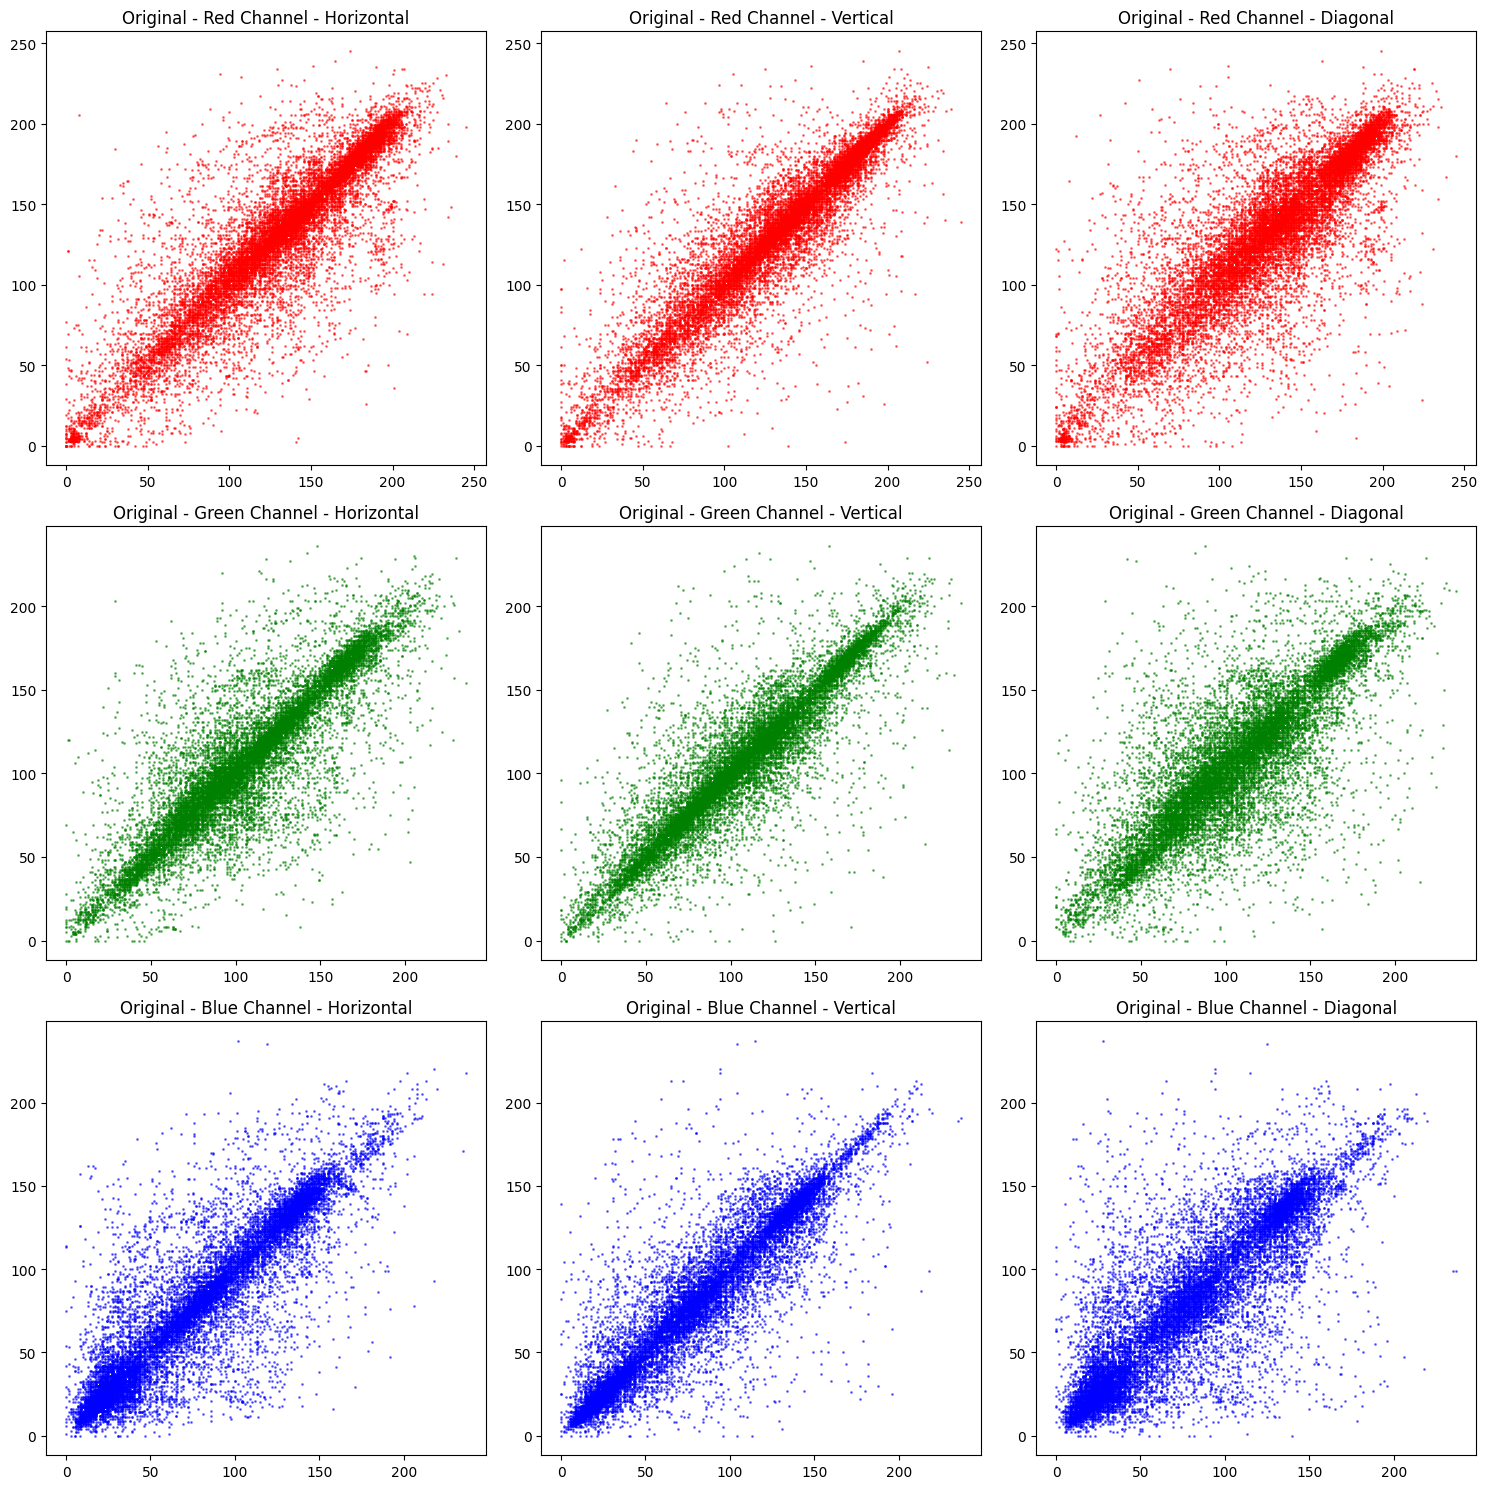

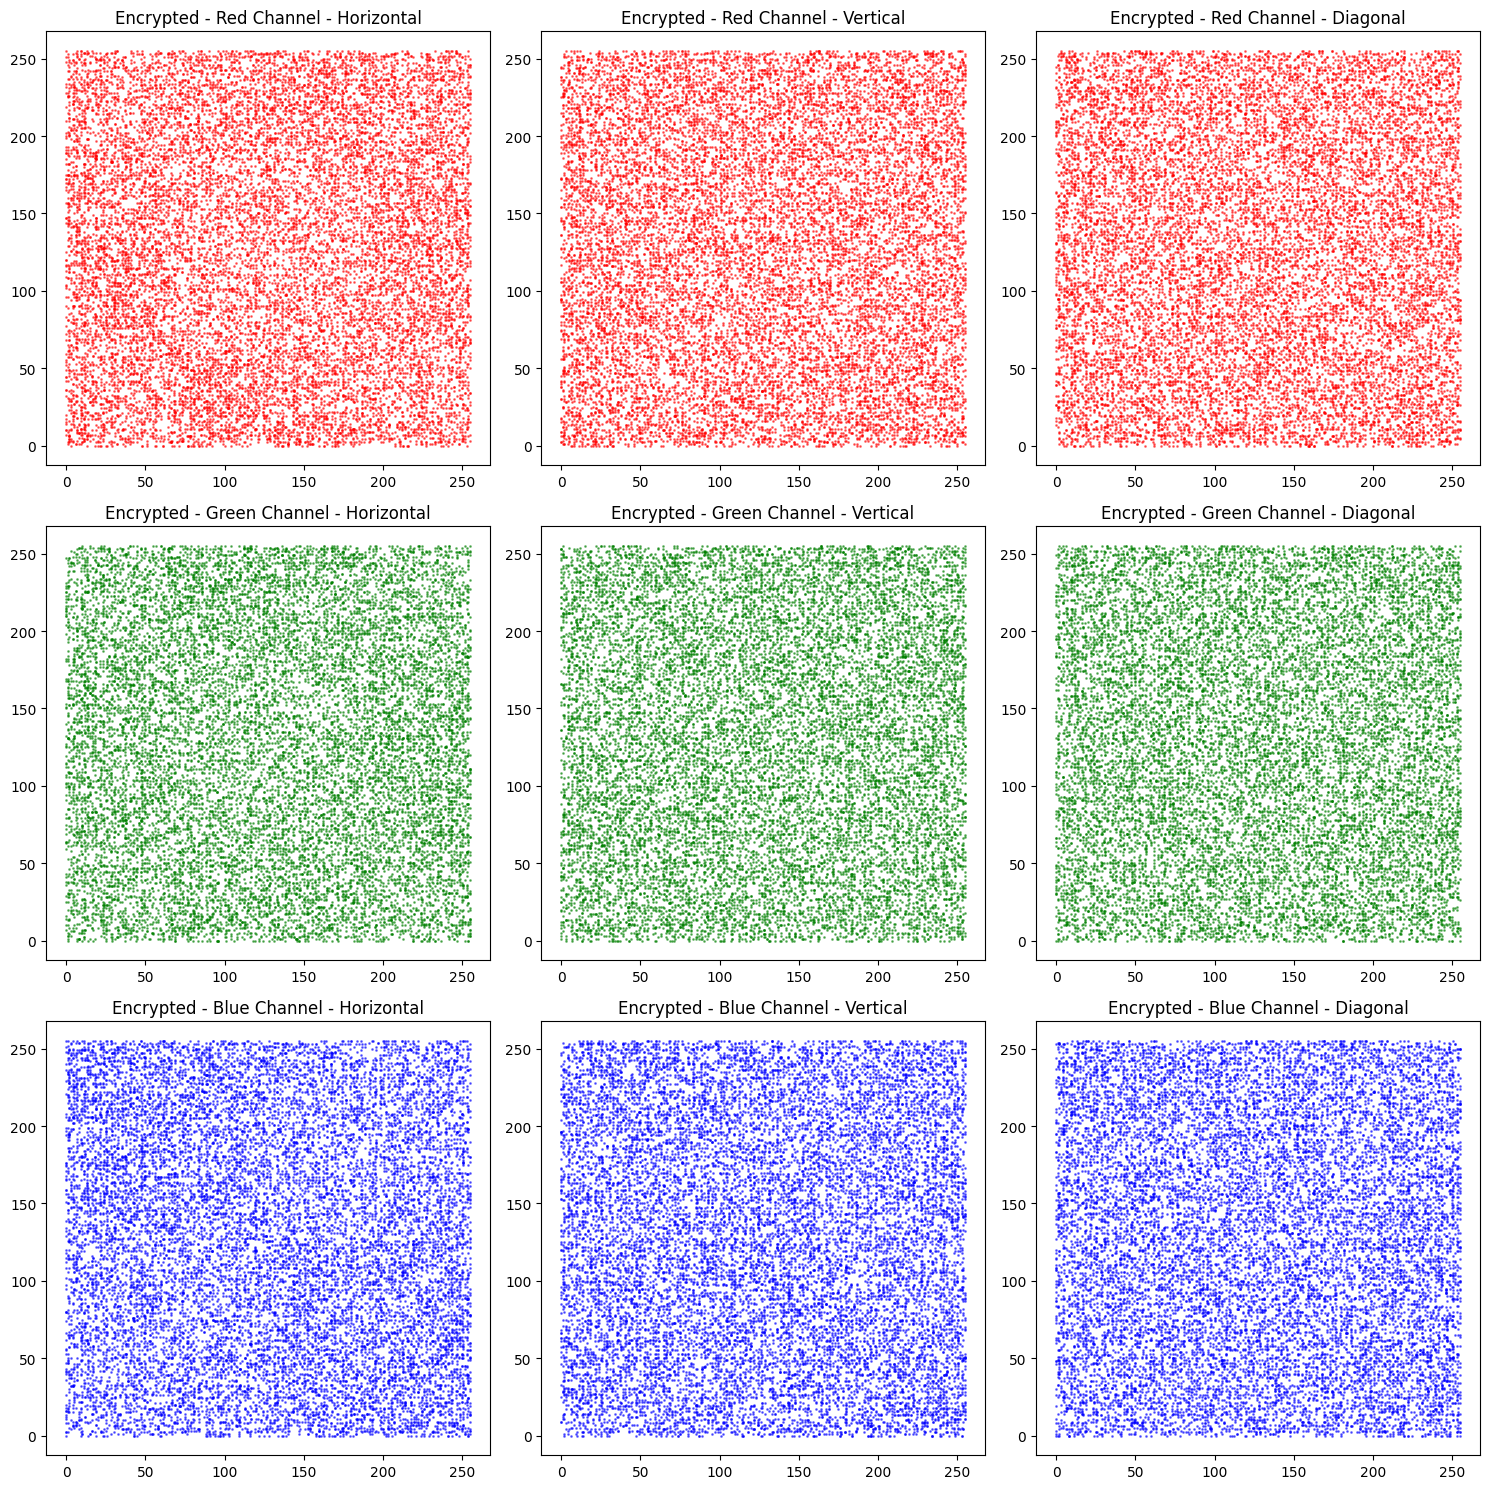

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate correlation for a given direction and color channel
def calculate_correlation(img, direction):
    if direction == "horizontal":
        img1, img2 = img[:, :-1], img[:, 1:]
    elif direction == "vertical":
        img1, img2 = img[:-1, :], img[1:, :]
    elif direction == "diagonal":
        img1, img2 = img[:-1, :-1], img[1:, 1:]
    else:
        raise ValueError("Invalid direction specified.")
    return img1.flatten(), img2.flatten()

# Select the original and encrypted images
original_img = images[0]  # Example: first original image
encrypted_img = encrypted_images[0]  # Corresponding encrypted image

# Color channels (Red, Green, Blue)
channels = ['Red', 'Green', 'Blue']
directions = ["horizontal", "vertical", "diagonal"]

# Plot correlation for original and encrypted images separately
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for ch_idx, color in enumerate(channels):
    for dir_idx, direction in enumerate(directions):
        # Calculate correlations for original and encrypted images
        orig_points_x, orig_points_y = calculate_correlation(original_img[:, :, ch_idx], direction)
        enc_points_x, enc_points_y = calculate_correlation(encrypted_img[:, :, ch_idx], direction)

        # Plot for original image correlations
        axs[ch_idx, dir_idx].scatter(orig_points_x, orig_points_y, color=color.lower(), alpha=0.5, s=1)
        axs[ch_idx, dir_idx].set_title(f"Original - {color} Channel - {direction.capitalize()}")

plt.tight_layout()
plt.show()

# Plot correlation for encrypted images
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for ch_idx, color in enumerate(channels):
    for dir_idx, direction in enumerate(directions):
        # Calculate correlations for encrypted images
        enc_points_x, enc_points_y = calculate_correlation(encrypted_img[:, :, ch_idx], direction)

        # Plot for encrypted image correlations
        axs[ch_idx, dir_idx].scatter(enc_points_x, enc_points_y, color=color.lower(), alpha=0.5, s=1)
        axs[ch_idx, dir_idx].set_title(f"Encrypted - {color} Channel - {direction.capitalize()}")

plt.tight_layout()
plt.show()


In [ ]:
# Initialize lists to store PSNR and SSIM values for original and decrypted images
psnr_decrypted_values = []
ssim_decrypted_values = []

# Calculate PSNR and SSIM for the first 5 original and decrypted image pairs
for i in range(5):
    original_img = images[i]
    decrypted_img = decrypted_images[i]

    try:
        # Calculate PSNR and SSIM
        psnr_value = psnr(original_img, decrypted_img, data_range=255)
        ssim_value = ssim(original_img, decrypted_img, win_size=3, channel_axis=-1, data_range=255)

        # Append results only if calculations succeed
        psnr_decrypted_values.append(psnr_value)
        ssim_decrypted_values.append(ssim_value)

    except Exception as e:
        print(f"Error processing image pair {i + 1}: {e}")

# Create DataFrames for both encrypted and decrypted results
df_encrypted = pd.DataFrame({
    'Image Index': image_indices,
    'PSNR (Encrypted)': psnr_values,
    'SSIM (Encrypted)': ssim_values
})

df_decrypted = pd.DataFrame({
    'Image Index': image_indices,
    'PSNR (Decrypted)': psnr_decrypted_values,
    'SSIM (Decrypted)': ssim_decrypted_values
})

# Display the tables
print("PSNR and SSIM for Original and Encrypted Images:")
print(df_encrypted)

print("\nPSNR and SSIM for Original and Decrypted Images:")
print(df_decrypted)


Error processing image pair 1: name 'psnr' is not defined
Error processing image pair 2: name 'psnr' is not defined
Error processing image pair 3: name 'psnr' is not defined
Error processing image pair 4: name 'psnr' is not defined
Error processing image pair 5: name 'psnr' is not defined


NameError: name 'image_indices' is not defined